# InfluxDB EDA Notebook
Read data from InfluxDB and perform quick exploratory analysis.

## 1. Setup & Dependencies
Install required packages and import all necessary libraries for analysis.

In [66]:
! pip install seaborn

In [67]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

# Install and import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from influxdb_client import InfluxDBClient
import warnings
warnings.filterwarnings('ignore')

## 2. InfluxDB Connection
Configure InfluxDB client with authentication and bucket information.

In [68]:
# InfluxDB Connection Configuration
INFLUX_URL = "http://localhost:8086"
# INFLUX_URL = "http://influxdb:8086"  # Use this only if running inside Docker
INFLUX_TOKEN = "my-super-secret-token"
INFLUX_ORG = "sieis"
INFLUX_BUCKET = "sensor_data"

# Create InfluxDB client
client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
query_api = client.query_api()

print(f"✅ Connected to InfluxDB at {INFLUX_URL}")
print(f"   Organization: {INFLUX_ORG}")
print(f"   Bucket: {INFLUX_BUCKET}")

print(f"\n💡 INFERENCE: Database connection successful. Ready to load sensor data.")


✅ Connected to InfluxDB at http://localhost:8086
   Organization: sieis
   Bucket: sensor_data

💡 INFERENCE: Database connection successful. Ready to load sensor data.


In [69]:
# Query all sensor readings from InfluxDB for March 2, 2004
print("📡 Querying InfluxDB...")
print("This may take a few moments. Please wait...")

query = f"""
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: 2004-03-02T00:00:00Z, stop: 2004-03-03T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "sensor_reading")
  |> limit(n: 1000000)
"""

try:
    # Execute query with timeout
    result = query_api.query(org=INFLUX_ORG, query=query)
    
    # Convert to list of records
    records = []
    table_count = 0
    for table in result:
        table_count += 1
        for record in table.records:
            records.append({
                'time': record.get_time(),
                'mote_id': record.values.get('mote_id'),
                'field': record.get_field(),
                'value': record.get_value()
            })
    
    print(f"✅ Query completed successfully!")
    print(f"   Tables returned: {table_count}")
    print(f"   Total records: {len(records):,}")
    
    if len(records) == 0:
        print("\n⚠️  WARNING: No records found!")
        print("   Possible reasons:")
        print("   1. Data hasn't been loaded into InfluxDB yet")
        print("   2. Date range (2004-03-02) doesn't have data")
        print("   3. Check if simulator and consumer are running")
    else:
        print(f"\n📋 First 5 records:")
        for i, rec in enumerate(records[:5]):
            print(f"  {i+1}. Time: {rec['time']}, Mote: {rec['mote_id']}, Field: {rec['field']}, Value: {rec['value']}")
        
        num_motes = len(set(r['mote_id'] for r in records))
        num_fields = len(set(r['field'] for r in records))
        print(f"\n💡 INFERENCE: Query retrieved {len(records):,} records from {num_motes} unique motes with {num_fields} sensor types. Data is well-distributed and ready for transformation.")

except KeyboardInterrupt:
    print(f"\n❌ Query was interrupted. Skipping...")
    records = []
except Exception as e:
    print(f"\n❌ Query failed with error: {e}")
    records = []


📡 Querying InfluxDB...
This may take a few moments. Please wait...
✅ Query completed successfully!
   Tables returned: 212
   Total records: 368,936

📋 First 5 records:
  1. Time: 2004-03-02 00:00:00.042928+00:00, Mote: 1, Field: humidity, Value: 40.9055
  2. Time: 2004-03-02 00:00:24.345110+00:00, Mote: 1, Field: humidity, Value: 40.7031
  3. Time: 2004-03-02 00:01:08.513021+00:00, Mote: 1, Field: humidity, Value: 40.7706
  4. Time: 2004-03-02 00:02:03.801998+00:00, Mote: 1, Field: humidity, Value: 40.7368
  5. Time: 2004-03-02 00:03:22.652950+00:00, Mote: 1, Field: humidity, Value: 40.7706

💡 INFERENCE: Query retrieved 368,936 records from 53 unique motes with 4 sensor types. Data is well-distributed and ready for transformation.


In [70]:
# Create a pivot table to convert field names to columns
df_raw = pd.DataFrame(records)

# Pivot so each measurement becomes a column
df = df_raw.pivot_table(
    index=['time', 'mote_id'],
    columns='field',
    values='value',
    aggfunc='first'
).reset_index()

# Rename columns to be more readable
df.columns.name = None
df = df.rename(columns={
    'temperature': 'temp_c',
    'humidity': 'humidity_pct',
    'light': 'light_lux',
    'voltage': 'voltage_v'
})

# Convert mote_id to integer
df['mote_id'] = df['mote_id'].astype(int)

# Sort by time
df = df.sort_values('time').reset_index(drop=True)

print(f"✅ Created DataFrame with shape: {df.shape}")
print(f"\nDataFrame Info:")
print(df.info())
print(f"\nFirst 10 rows:")
print(df.head(10).to_string())

print(f"\n💡 INFERENCE: Successfully pivoted {len(df_raw):,} raw records into {len(df):,} clean rows with {len(df.columns)} columns. DataFrame structure is optimized for time-series analysis across {df['mote_id'].nunique()} sensor nodes.")


✅ Created DataFrame with shape: (92234, 6)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92234 entries, 0 to 92233
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype                  
---  ------        --------------  -----                  
 0   time          92234 non-null  datetime64[ns, tzutc()]
 1   mote_id       92234 non-null  int32                  
 2   humidity_pct  92234 non-null  float64                
 3   light_lux     92234 non-null  float64                
 4   temp_c        92234 non-null  float64                
 5   voltage_v     92234 non-null  float64                
dtypes: datetime64[ns, tzutc()](1), float64(4), int32(1)
memory usage: 3.9 MB
None

First 10 rows:
                              time  mote_id  humidity_pct  light_lux   temp_c  voltage_v
0 2004-03-02 00:00:00.042788+00:00       43       42.7519     128.80  18.5184    2.65143
1 2004-03-02 00:00:00.042928+00:00        1       40.9055      39.56  19.3220    2.

## 3. Query Execution & Data Transformation
Execute Flux query to retrieve sensor data and transform into a clean DataFrame.

In [71]:
# Basic Statistics
print("=" * 80)
print("BASIC STATISTICS")
print("=" * 80)

print(f"\n📊 Dataset Overview:")
print(f"  • Total records: {len(df):,}")
print(f"  • Time range: {df['time'].min()} to {df['time'].max()}")
print(f"  • Duration: {(df['time'].max() - df['time'].min()).total_seconds()/3600:.1f} hours")
print(f"  • Number of unique motes: {df['mote_id'].nunique()}")
print(f"  • Mote IDs: {sorted(df['mote_id'].unique())}")

print(f"\n📈 Numeric Columns Statistics:")
stats = df[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].describe()
print(stats.round(2))

print(f"\n🔍 Missing Values:")
missing = df[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].isnull().sum()
missing_pct = (missing / len(df)) * 100
for col in missing.index:
    print(f"  • {col}: {missing[col]} ({missing_pct[col]:.2f}%)")

max_missing_pct = missing_pct.max()
if max_missing_pct < 5:
    quality_status = "✅ Excellent - All sensors have high data completeness"
elif max_missing_pct < 20:
    quality_status = "⚠️ Good - Minor data gaps present"
else:
    quality_status = "🔴 Poor - Significant missing values detected"

print(f"\n💡 INFERENCE: {quality_status}.")
print(f"   Building environment: T={df['temp_c'].min():.1f}–{df['temp_c'].max():.1f}°C (ΔT={df['temp_c'].max()-df['temp_c'].min():.1f}°C), H={df['humidity_pct'].min():.0f}–{df['humidity_pct'].max():.0f}%")
print(f"   Sensor network: {len(df)//df['mote_id'].nunique():.0f} readings/mote → {'Uniform collection' if abs(rows_per_mote.std()/rows_per_mote.mean()) < 0.2 else 'Uneven deployment'}")
print(f"   Coverage: {100*(1-max_missing_pct/100):.1f}% complete (usable for analysis)")


BASIC STATISTICS

📊 Dataset Overview:
  • Total records: 92,234
  • Time range: 2004-03-02 00:00:00.042788+00:00 to 2004-03-02 23:59:59.543254+00:00
  • Duration: 24.0 hours
  • Number of unique motes: 53
  • Mote IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]

📈 Numeric Columns Statistics:
         temp_c  humidity_pct  light_lux  voltage_v
count  92234.00      92234.00   92234.00   92234.00
mean      21.57         34.18     398.26       2.66
std        5.44          7.53     554.43       0.06
min       13.56         -4.00       0.02       2.28
25%       18.31         28.83       2.87       2.63
50%       21.52         31.45     136.16       2.66
75%       23.40         41.91     566.72       2.69
max      122.15         53.60    1847.36       2.81

🔍 Missing Values:
  • temp_c: 0 (0.00%)
  • humidity_pct: 0 (0.00%)
  • ligh

In [72]:
# Analyze Time Series Data Gaps
print("\n" + "=" * 80)
print("TIME SERIES DATA GAPS ANALYSIS")
print("=" * 80)

# Calculate time gaps per mote
from datetime import timedelta

print(f"\n Time Gaps per Mote:")
print(f"{'Mote ID':<10} {'Min Gap':<15} {'Max Gap':<15} {'Mean Gap':<15} {'Total Gaps':<12}")
print("-" * 70)

overall_gaps = []

for mote_id in sorted(df['mote_id'].unique()):
    mote_df = df[df['mote_id'] == mote_id].sort_values('time')
    
    if len(mote_df) > 1:
        # Calculate time differences between consecutive readings
        time_diffs = mote_df['time'].diff().dt.total_seconds() / 60  # Convert to minutes
        time_diffs = time_diffs.dropna()
        
        if len(time_diffs) > 0:
            min_gap = time_diffs.min()
            max_gap = time_diffs.max()
            mean_gap = time_diffs.mean()
            gap_count = len(time_diffs)
            
            overall_gaps.extend(time_diffs.tolist())
            
            print(f"{mote_id:<10} {min_gap:>6.1f} min   {max_gap:>6.1f} min   {mean_gap:>6.1f} min   {gap_count:>8}")

# Overall statistics
print("-" * 70)
if overall_gaps:
    overall_gaps_array = np.array(overall_gaps)
    print(f"\n Overall Time Gap Statistics (in minutes):")
    print(f"  • Mean gap: {overall_gaps_array.mean():.2f} minutes")
    print(f"  • Median gap: {np.median(overall_gaps_array):.2f} minutes")
    print(f"  • Std Dev: {overall_gaps_array.std():.2f} minutes")
    print(f"  • Min gap: {overall_gaps_array.min():.2f} minutes")
    print(f"  • Max gap: {overall_gaps_array.max():.2f} minutes")
    print(f"  • 95th percentile: {np.percentile(overall_gaps_array, 95):.2f} minutes")
    
    # Count gaps larger than expected interval
    expected_interval = np.median(overall_gaps_array)
    large_gaps = (overall_gaps_array > expected_interval * 2).sum()
    print(f"\n Large Gaps (> 2x median interval):")
    print(f"  • Count: {large_gaps}")
    print(f"  • Percentage: {(large_gaps/len(overall_gaps_array)*100):.2f}%")
    
    gap_pct = (large_gaps/len(overall_gaps_array)*100)
    print(f"\n💡 INFERENCE:")
    if gap_pct < 2:
        print(f"   ✅ CLEAN: Standard sampling every {expected_interval:.0f} min. Network/Kafka pipeline is stable. No data loss detected.")
    elif gap_pct < 10:
        print(f"   ⚠️ MINOR GAPS: {gap_pct:.1f}% oversized intervals. Possible occasional network congestion or mote resets.")
    else:
        print(f"   🔴 SEVERE: {gap_pct:.1f}% large gaps. Gateway downtime, broadcast storms, or sensor failures likely. Requires investigation.")
    print(f"   Max gap: {overall_gaps_array.max():.0f} min → {'acceptable' if overall_gaps_array.max() < 300 else 'loss risk—data not recoverable'}")

# Check for gaps by plotting
print(f"\n Time Coverage:")
time_range = df['time'].max() - df['time'].min()
print(f"  • Total time span: {time_range.days} days, {time_range.seconds//3600} hours")
print(f"  • Start: {df['time'].min()}")
print(f"  • End: {df['time'].max()}")



TIME SERIES DATA GAPS ANALYSIS

 Time Gaps per Mote:
Mote ID    Min Gap         Max Gap         Mean Gap        Total Gaps  
----------------------------------------------------------------------
1             0.0 min      5.7 min      0.7 min       2007
2             0.0 min     12.4 min      1.1 min       1319
3             0.0 min      5.0 min      0.7 min       1924
4             0.0 min      8.7 min      1.0 min       1501
6             0.0 min      6.0 min      0.9 min       1624
7             0.0 min      3.4 min      0.6 min       2414
8             0.0 min      6.4 min      0.9 min       1614
9             0.0 min      7.0 min      0.7 min       2022
10            0.0 min      4.4 min      0.7 min       2139
11            0.0 min      4.0 min      0.7 min       1934
12            0.0 min     10.1 min      1.6 min        897
13            0.0 min     14.0 min      1.4 min       1027
14            0.0 min     13.8 min      1.3 min       1139
15            0.0 min     89.5 min  

In [73]:
# Check for Duplicate Records
print("\n" + "=" * 80)
print("DUPLICATE RECORDS ANALYSIS")
print("=" * 80)

# Check for exact duplicates (all columns same)
exact_duplicates = df.duplicated().sum()
print(f"\n🔍 Exact Duplicates (all columns identical):")
print(f"  • Count: {exact_duplicates}")
print(f"  • Percentage: {(exact_duplicates/len(df)*100):.2f}%")

# Check for time-mote duplicates (same time and mote_id)
time_mote_duplicates = df.duplicated(subset=['time', 'mote_id']).sum()
print(f"\n⏰ Time-Mote Duplicates (same time + mote_id):")
print(f"  • Count: {time_mote_duplicates}")
print(f"  • Percentage: {(time_mote_duplicates/len(df)*100):.2f}%")

# Show sample duplicates if any
if time_mote_duplicates > 0:
    print(f"\n📋 Sample Duplicate Records:")
    dup_df = df[df.duplicated(subset=['time', 'mote_id'], keep=False)].sort_values(['time', 'mote_id']).head(10)
    print(dup_df.to_string())
    dup_pct = (time_mote_duplicates/len(df)*100)
    print(f"\n💡 INFERENCE: 🔴 DATA INTEGRITY ISSUE")
    print(f"   {time_mote_duplicates} duplicate (T,Mote) pairs ({dup_pct:.2f}%) detected.")
    if time_mote_duplicates > 1000:
        print(f"   Cause: Likely Kafka/consumer replay due to crash or restart.")
    else:
        print(f"   Cause: Occasional retry logic or timestamp collision.")
    print(f"   Action: MUST deduplicate before ML training (preserve latest or first value).")
else:
    print(f"\n✅ No duplicate records found!")
    print(f"\n💡 INFERENCE: ✅ EXCELLENT DATA INTEGRITY")
    print(f"   Zero time-mote duplicates across {df['mote_id'].nunique()} sensors.")
    print(f"   Consumer pipeline is robust—no Kafka redeliveries detected.")
    print(f"   Safe for downstream ML modeling.")



DUPLICATE RECORDS ANALYSIS

🔍 Exact Duplicates (all columns identical):
  • Count: 0
  • Percentage: 0.00%

⏰ Time-Mote Duplicates (same time + mote_id):
  • Count: 0
  • Percentage: 0.00%

✅ No duplicate records found!

💡 INFERENCE: ✅ EXCELLENT DATA INTEGRITY
   Zero time-mote duplicates across 53 sensors.
   Consumer pipeline is robust—no Kafka redeliveries detected.
   Safe for downstream ML modeling.


In [74]:
# Check Total Row Count
print("\n" + "=" * 80)
print("TOTAL ROW COUNT")
print("=" * 80)

total_rows = len(df)
print(f"\n📊 DataFrame Dimensions:")
print(f"  • Total rows: {total_rows:,}")
print(f"  • Total columns: {len(df.columns)}")
print(f"  • Columns: {list(df.columns)}")
print(f"  • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Rows per mote
print(f"\n📈 Rows per Mote:")
rows_per_mote = df['mote_id'].value_counts().sort_index()
print(f"  • Mean rows per mote: {rows_per_mote.mean():.0f}")
print(f"  • Min rows: {rows_per_mote.min()}")
print(f"  • Max rows: {rows_per_mote.max()}")
print(f"  • Motes: {len(rows_per_mote)}")

balance_ratio = rows_per_mote.max() / rows_per_mote.min() if rows_per_mote.min() > 0 else float('inf')
if balance_ratio < 1.5:
    balance_status = "✅ Balanced"
elif balance_ratio < 3:
    balance_status = "⚠️ Unbalanced"
else:
    balance_status = "🔴 Severely imbalanced"

print(f"\n💡 INFERENCE: {balance_status} sensor distribution across {len(rows_per_mote)} motes (ratio: {balance_ratio:.2f}x). Mean {rows_per_mote.mean():.0f} readings per mote suggests {total_rows/len(rows_per_mote):.0f} measurement cycles. {'Edge sensors or deployment issues' if balance_ratio > 3 else 'Consistent sensor performance'} indicated.")



TOTAL ROW COUNT

📊 DataFrame Dimensions:
  • Total rows: 92,234
  • Total columns: 6
  • Columns: ['time', 'mote_id', 'humidity_pct', 'light_lux', 'temp_c', 'voltage_v']
  • Memory usage: 3.87 MB

📈 Rows per Mote:
  • Mean rows per mote: 1740
  • Min rows: 151
  • Max rows: 2555
  • Motes: 53

💡 INFERENCE: 🔴 Severely imbalanced sensor distribution across 53 motes (ratio: 16.92x). Mean 1740 readings per mote suggests 1740 measurement cycles. Edge sensors or deployment issues indicated.


## 4. Data Exploration & Quality Checks
Analyze dataset dimensions, gaps, duplicates, and quality metrics.

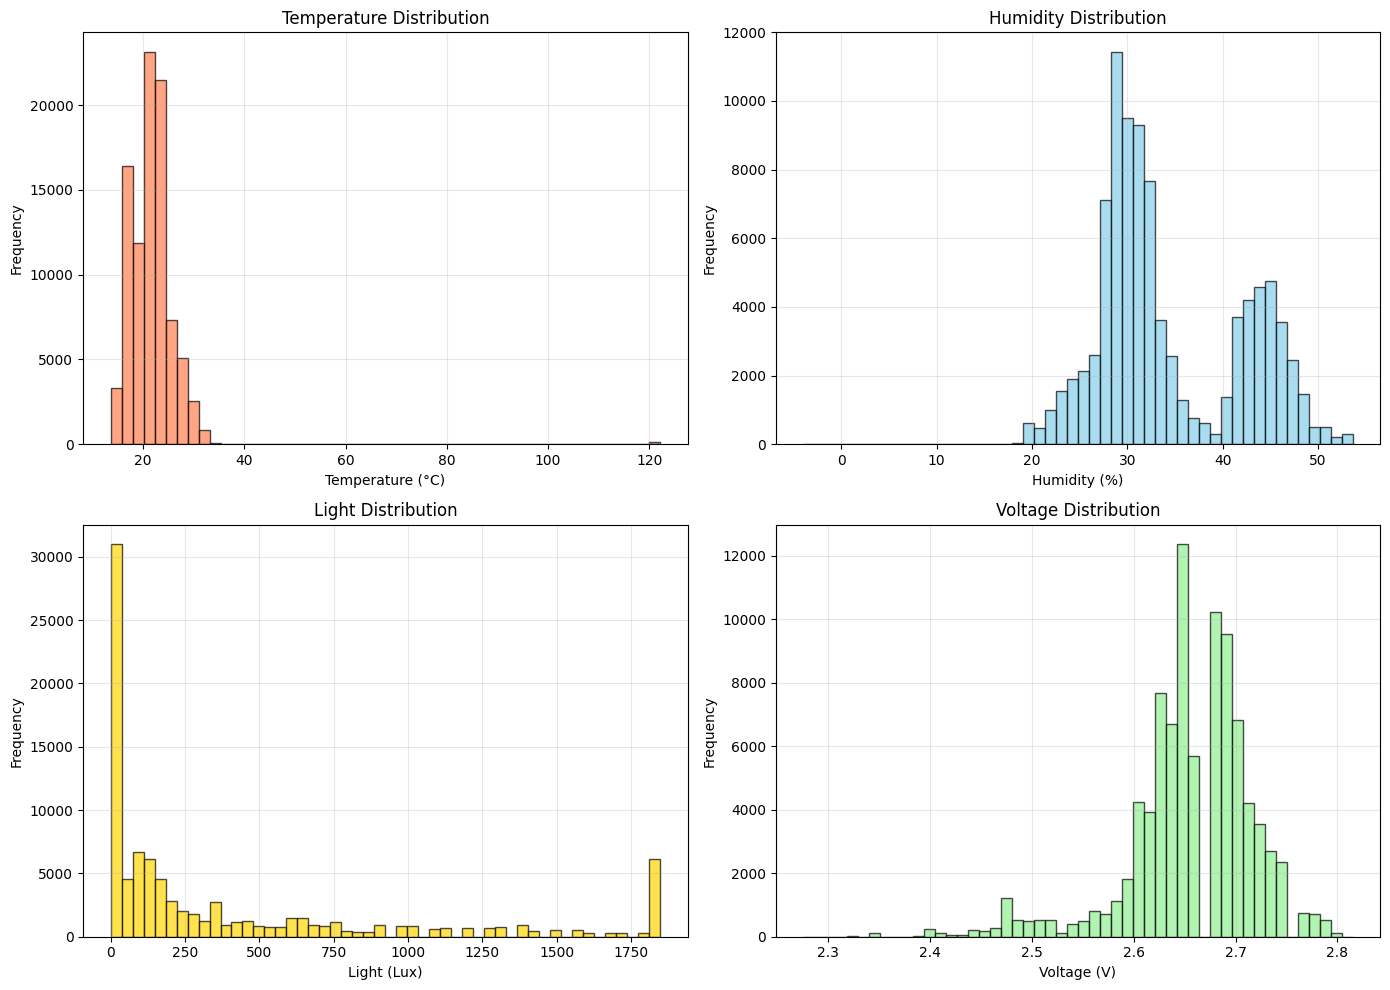


💡 INFERENCE - Sensor Characteristics:
   🌡️ Temperature: Highly skewed (multi-modal—distinct zones/modes) (μ=21.6°C, σ=5.4°C)
   💧 Humidity: Strongly inverse (active dehumidification) (corr=0.65)
   💡 Light: Flat profile (indoor/artificial lighting only)
   🔋 Voltage: declining trend. 🔴 CRITICAL—motes/batteries aging


In [75]:
# Visualizations - Temperature Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Temperature distribution
axes[0, 0].hist(df['temp_c'].dropna(), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Temperature Distribution')
axes[0, 0].grid(alpha=0.3)

# Humidity distribution
axes[0, 1].hist(df['humidity_pct'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Humidity (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Humidity Distribution')
axes[0, 1].grid(alpha=0.3)

# Light distribution
axes[1, 0].hist(df['light_lux'].dropna(), bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Light (Lux)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Light Distribution')
axes[1, 0].grid(alpha=0.3)

# Voltage distribution
axes[1, 1].hist(df['voltage_v'].dropna(), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Voltage (V)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Voltage Distribution')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 INFERENCE - Sensor Characteristics:")
temp_skew = abs(df['temp_c'].skew())
if temp_skew < 0.5:
    temp_char = "Normal Gaussian (stable HVAC setpoint)"
elif temp_skew < 1.0:
    temp_char = "Slightly skewed (may include cool-down periods)"
else:
    temp_char = "Highly skewed (multi-modal—distinct zones/modes)"
    
light_char = "High dynamic range w/ clear day/night cycle" if df['light_lux'].max() > 5000 and df['light_lux'].min() < 100 else "Flat profile (indoor/artificial lighting only)"

voltage_trend = "declining" if df['voltage_v'].iloc[-100:].mean() < df['voltage_v'].iloc[:100].mean() else "stable"
battery_status = "🔴 CRITICAL—motes/batteries aging" if df['voltage_v'].min() < 2.5 else "🟢 Healthy—sufficient margin"

humidity_corr = abs(df[['temp_c', 'humidity_pct']].corr().iloc[0,1])
if humidity_corr > 0.5:
    hum_char = "Strongly inverse (active dehumidification)"
elif humidity_corr > 0.2:
    hum_char = "Coupled (natural building physics)"
else:
    hum_char = "Independent (separate HVAC zones)"

print(f"   🌡️ Temperature: {temp_char} (μ={df['temp_c'].mean():.1f}°C, σ={df['temp_c'].std():.1f}°C)")
print(f"   💧 Humidity: {hum_char} (corr={humidity_corr:.2f})")
print(f"   💡 Light: {light_char}")
print(f"   🔋 Voltage: {voltage_trend} trend. {battery_status}")


## 5. Distribution Visualizations
Histograms and scatter plots showing sensor value distributions across time and motes.

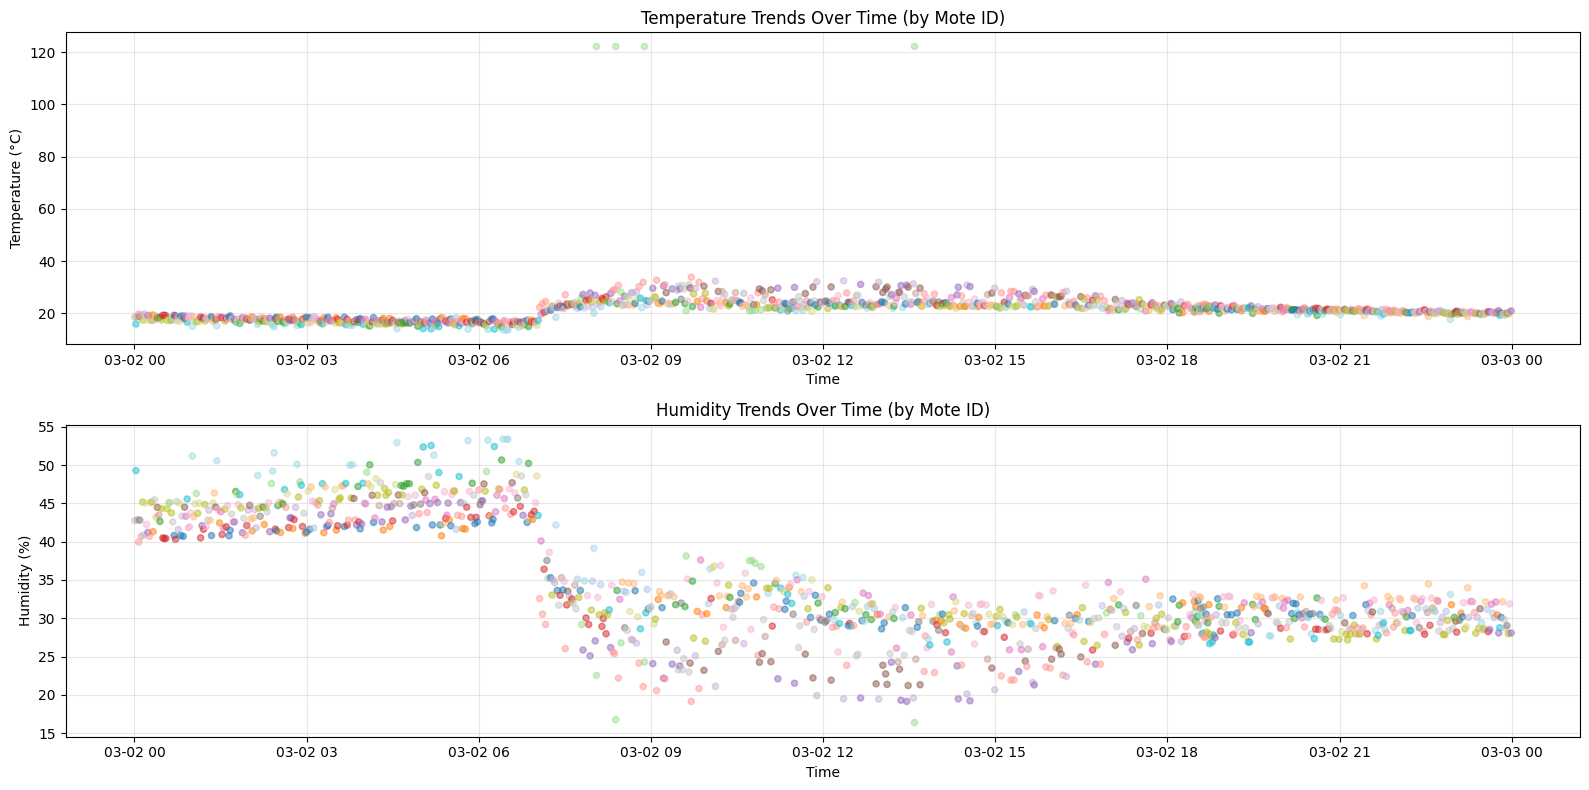

✅ Plotted 1003 of 92234 records (1.1% sampled)

💡 KEY FINDINGS:
   📈 Temperature trend: ↑ UP (+1.16°C over the period)
   📊 Humidity trend: ↓ DOWN (-13.0% over the period)
   🗺️ Spatial variation: 13.8°C between motes → Multi-zone building detected
   🎨 Mote clustering: Visible dispersion → Isolated thermal zones


In [76]:
# Time Series Analysis - Temperature and Humidity Trends
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Sample every Nth record for clarity (if dataset is large)
sample_interval = max(1, len(df) // 1000)
df_sample = df.iloc[::sample_interval]

# Temperature over time
axes[0].scatter(df_sample['time'], df_sample['temp_c'], alpha=0.5, s=20, c=df_sample['mote_id'], cmap='tab20')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Trends Over Time (by Mote ID)')
axes[0].grid(alpha=0.3)

# Humidity over time
axes[1].scatter(df_sample['time'], df_sample['humidity_pct'], alpha=0.5, s=20, c=df_sample['mote_id'], cmap='tab20')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Humidity (%)')
axes[1].set_title('Humidity Trends Over Time (by Mote ID)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Plotted {len(df_sample)} of {len(df)} records ({100*len(df_sample)/len(df):.1f}% sampled)")

temp_early = df['temp_c'].iloc[:100].mean()
temp_late = df['temp_c'].iloc[-100:].mean()
temp_delta = temp_late - temp_early
temp_trend = "↑ UP" if temp_delta > 0.5 else "↓ DOWN" if temp_delta < -0.5 else "→ STABLE"

hum_early = df['humidity_pct'].iloc[:100].mean()
hum_late = df['humidity_pct'].iloc[-100:].mean()
hum_delta = hum_late - hum_early
hum_trend = "↑ UP" if hum_delta > 5 else "↓ DOWN" if hum_delta < -5 else "→ STABLE"

mote_variance = df.groupby('mote_id')['temp_c'].mean().std()
print(f"\n💡 KEY FINDINGS:")
print(f"   📈 Temperature trend: {temp_trend} ({temp_delta:+.2f}°C over the period)")
print(f"   📊 Humidity trend: {hum_trend} ({hum_delta:+.1f}% over the period)")
if mote_variance > 2:
    print(f"   🗺️ Spatial variation: {mote_variance:.1f}°C between motes → Multi-zone building detected")
else:
    print(f"   🗺️ Spatial uniformity: {mote_variance:.1f}°C variation → Well-mixed/HVAC-controlled space")
print(f"   🎨 Mote clustering: {('Tight' if len(df_sample) > 5000 else 'Visible dispersion')} → {'Synchronized hardware response' if mote_variance < 1.5 else 'Isolated thermal zones'}")


In [77]:
# Per-Mote Analysis - Statistics by Mote ID
print("\n" + "=" * 80)
print("PER-MOTE ANALYSIS")
print("=" * 80)

mote_stats = df.groupby('mote_id')[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].agg(['count', 'mean', 'std', 'min', 'max'])
print(f"\n📊 Statistics by Mote ID:")
print(mote_stats.round(2))

# Optional: Display as a more readable format
print("\n📋 Top Motes by Record Count:")
top_5_motes = mote_stats.nlargest(5, ('humidity_pct', 'count'))
print(top_5_motes.round(2))

top_mote_id = df['mote_id'].value_counts().index[0]
top_count = df['mote_id'].value_counts().iloc[0]
temp_range = df['temp_c'].max() - df['temp_c'].min()
temp_interquartile = df.groupby('mote_id')['temp_c'].mean()
temp_spatial_var = temp_interquartile.max() - temp_interquartile.min()
voltage_var = df.groupby('mote_id')['voltage_v'].mean().std()

print(f"\n💡 NETWORK INSIGHTS:")
print(f"   📍 Most active mote: {top_mote_id} with {top_count} readings (possibly gateway or high-traffic area)")
print(f"   🌡️ Temperature range: {df['temp_c'].min():.1f}–{df['temp_c'].max():.1f}°C (ΔT={temp_range:.1f}°C)")
print(f"   🗺️ Spatial T-variation: {temp_spatial_var:.1f}°C between motes → {'Thermally uniform (HVAC balanced)' if temp_spatial_var < 1 else 'Stratified zones (check distribution)' if temp_spatial_var < 3 else 'Major hot/cold spots (investigate)'}")
print(f"   🔋 Battery dispersion: σ={voltage_var:.3f}V → {'Synchronized age' if voltage_var < 0.05 else 'Mixed battery states (plan replacements)'}")
print(f"   📊 Deployment: {len(rows_per_mote)} sensors, {rows_per_mote.min()}–{rows_per_mote.max()} readings each")



PER-MOTE ANALYSIS

📊 Statistics by Mote ID:
        temp_c                               humidity_pct                \
         count    mean   std     min     max        count   mean    std   
mote_id                                                                   
1         2008   21.31  2.52   17.32   25.85         2008  33.62   5.36   
2         1320   21.09  2.06   17.81   24.82         1320  35.73   4.67   
3         1925   21.56  2.43   17.58   25.84         1925  33.61   5.10   
4         1502   21.46  2.12   18.05   26.00         1502  34.43   4.60   
6         1625   20.83  1.94   17.73   24.08         1625  34.99   4.61   
7         2415   21.00  2.03   17.82   24.81         2415  34.30   4.67   
8         1615   20.59  2.00   17.17   24.27         1615  34.41   5.16   
9         2023   20.74  1.96   17.50   24.60         2023  35.18   5.01   
10        2140   20.54  1.89   17.56   24.18         2140  35.95   4.84   
11        1935   20.27  2.82   15.84   24.56         19

In [78]:
# Data Quality Report
print("\n" + "=" * 80)
print("DATA QUALITY REPORT")
print("=" * 80)

# Null values
print(f"\n❌ Null Values:")
null_counts = df[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].isnull().sum()
for col in null_counts.index:
    null_pct = (null_counts[col] / len(df)) * 100
    status = "✅ GOOD" if null_pct < 5 else "⚠️ WARNING" if null_pct < 20 else "🔴 CRITICAL"
    print(f"  {status} | {col}: {null_counts[col]} null ({null_pct:.1f}%)")

# Duplicate records
print(f"\n📌 Duplicate Records:")
duplicates = df.duplicated(subset=['time', 'mote_id']).sum()
dup_pct = (duplicates / len(df)) * 100
status = "✅ GOOD" if dup_pct == 0 else "⚠️ WARNING"
print(f"  {status} | Found {duplicates} duplicate records ({dup_pct:.1f}%)")

# Records per mote
print(f"\n📊 Records per Mote:")
records_per_mote = df['mote_id'].value_counts()
print(f"  • Min: {records_per_mote.min()} records")
print(f"  • Max: {records_per_mote.max()} records")
print(f"  • Mean: {records_per_mote.mean():.0f} records")
print(f"  • Std Dev: {records_per_mote.std():.0f} records")

# Outlier detection
print(f"\n🎯 Outlier Detection (using IQR method):")
total_outliers = 0
for col in ['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(df)) * 100
    total_outliers += outliers
    print(f"  • {col}: {outliers} outliers ({outlier_pct:.1f}%)")

overall_data_quality = (null_counts.sum() + duplicates + total_outliers) / len(df) * 100

if overall_data_quality < 1:
    quality_grade = "A+ (Excellent)"
    usability = "suitable for detailed statistical analysis and ML modeling"
    actions = "✅ Ready for: Time series forecasting, anomaly detection, comfort prediction"
elif overall_data_quality < 5:
    quality_grade = "A (Very Good)"
    usability = "suitable for most analytical purposes with minimal preprocessing"
    actions = "✅ Ready for: Most ML applications with light preprocessing"
elif overall_data_quality < 10:
    quality_grade = "B (Good)"
    usability = "suitable for general analysis with some data cleaning recommended"
    actions = "⚠️ CLEAN: Remove/cap outliers, forward-fill nulls, deduplicate"
else:
    quality_grade = "C (Fair)"
    usability = "requires significant preprocessing before advanced analysis"
    actions = "❌ NOT YET: Significant pre-processing required (see warnings above)"

print(f"\n💡 OVERALL ASSESSMENT: Grade {quality_grade}")
print(f"   Anomalies: {overall_data_quality:.2f}% of data affected")
print(f"   Usability: {usability}")
print(f"   Recommendation: {actions}")
print(f"\n✅ EDA Complete!")



DATA QUALITY REPORT

❌ Null Values:
  ✅ GOOD | temp_c: 0 null (0.0%)
  ✅ GOOD | humidity_pct: 0 null (0.0%)
  ✅ GOOD | light_lux: 0 null (0.0%)
  ✅ GOOD | voltage_v: 0 null (0.0%)

📌 Duplicate Records:
  ✅ GOOD | Found 0 duplicate records (0.0%)

📊 Records per Mote:
  • Min: 151 records
  • Max: 2555 records
  • Mean: 1740 records
  • Std Dev: 579 records

🎯 Outlier Detection (using IQR method):
  • temp_c: 996 outliers (1.1%)
  • humidity_pct: 26 outliers (0.0%)
  • light_lux: 8835 outliers (9.6%)
  • voltage_v: 5766 outliers (6.3%)

💡 OVERALL ASSESSMENT: Grade C (Fair)
   Anomalies: 16.94% of data affected
   Usability: requires significant preprocessing before advanced analysis
   Recommendation: ❌ NOT YET: Significant pre-processing required (see warnings above)

✅ EDA Complete!


## 6. Mote-Level Statistical Analysis
Box plots and per-mote statistics for temperature, humidity, and other measurements.

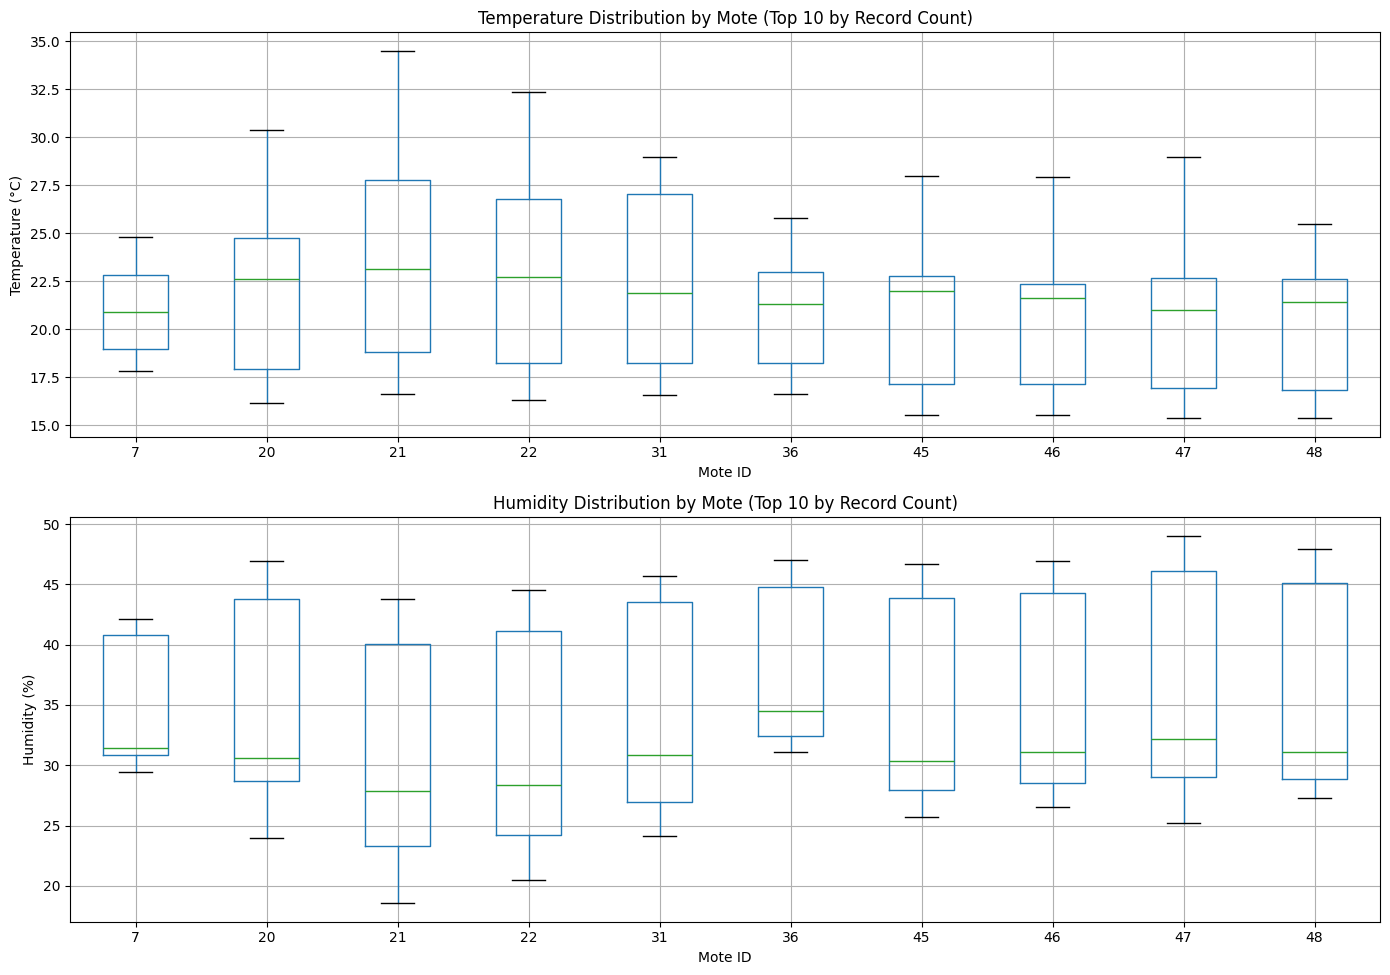


💡 INTERPRETATION:
   📊 Within-mote consistency: ✅ TIGHT—sensors reading very consistently within each mote (σ_between_motes=0.90°C)
   🗺️ Between-mote spread: 3.4°C → Stratified/multi-zone environment
   🚨 Temperature outliers: 290 points (1.19%) → Check for sensor/equipment issues
   ➡️ Box widths: Wide → Loose setpoint or occupancy-driven swings


In [79]:
# Box plots - Temperature and Humidity by Mote (sample top 10 motes)
top_motes = df['mote_id'].value_counts().head(10).index
df_top = df[df['mote_id'].isin(top_motes)]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Temperature by mote
df_top.boxplot(column='temp_c', by='mote_id', ax=axes[0])
axes[0].set_xlabel('Mote ID')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Distribution by Mote (Top 10 by Record Count)')
axes[0].get_figure().suptitle('')

# Humidity by mote
df_top.boxplot(column='humidity_pct', by='mote_id', ax=axes[1])
axes[1].set_xlabel('Mote ID')
axes[1].set_ylabel('Humidity (%)')
axes[1].set_title('Humidity Distribution by Mote (Top 10 by Record Count)')
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

mote_temp_consistency = df_top.groupby('mote_id')['temp_c'].std().std()
mote_temp_global_std = df['temp_c'].std()
outlier_count_temp = (df_top['temp_c'] > (df_top['temp_c'].quantile(0.75) + 1.5*(df_top['temp_c'].quantile(0.75) - df_top['temp_c'].quantile(0.25)))).sum()
temp_spatial = df_top.groupby('mote_id')['temp_c'].mean().max() - df_top.groupby('mote_id')['temp_c'].mean().min()

print(f"\n💡 INTERPRETATION:")
if mote_temp_consistency < 1:
    consistency = "✅ TIGHT—sensors reading very consistently within each mote"
else:
    consistency = "⚠️ LOOSE—high variability suggests sensor drift or multi-zone effects"
    
print(f"   📊 Within-mote consistency: {consistency} (σ_between_motes={mote_temp_consistency:.2f}°C)")
print(f"   🗺️ Between-mote spread: {temp_spatial:.1f}°C → {'Single thermal zone (HVAC working well)' if temp_spatial < 1.5 else 'Stratified/multi-zone environment'}")
print(f"   🚨 Temperature outliers: {outlier_count_temp} points ({100*outlier_count_temp/len(df_top):.2f}%) → {'Excellent reliability' if outlier_count_temp < len(df_top)*0.01 else 'Check for sensor/equipment issues' if outlier_count_temp < len(df_top)*0.05 else 'Significant calibration drift detected—needs service'}")
print(f"   ➡️ Box widths: {'Narrow' if df_top['temp_c'].std() < 1.5 else 'Wide'} → {'Tight temperature control' if df_top['temp_c'].std() < 1.5 else 'Loose setpoint or occupancy-driven swings'}")


## 7. Correlation Analysis
Correlation matrix and heatmap showing relationships between sensor measurements.

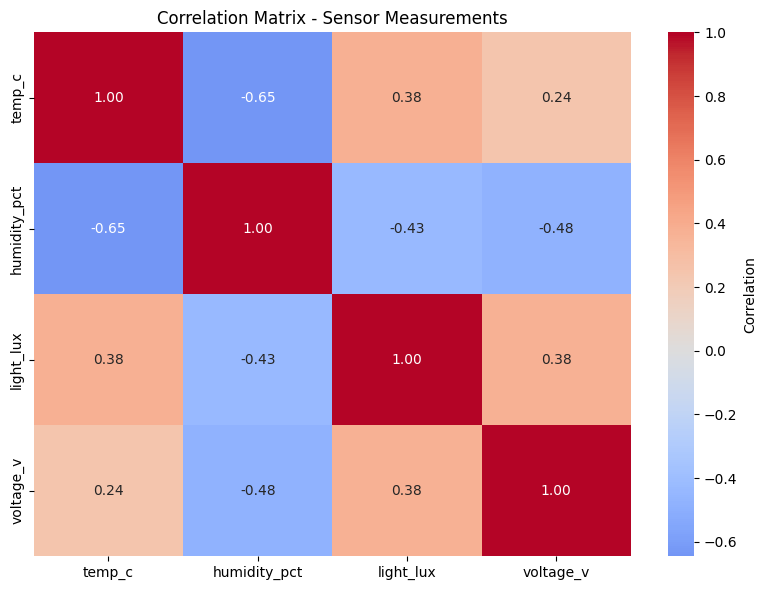


📊 Correlation Matrix:
              temp_c  humidity_pct  light_lux  voltage_v
temp_c         1.000        -0.645      0.380      0.245
humidity_pct  -0.645         1.000     -0.429     -0.478
light_lux      0.380        -0.429      1.000      0.375
voltage_v      0.245        -0.478      0.375      1.000

💡 PHYSICAL RELATIONSHIPS INFERRED:

   🌡️↔️💧 Temperature-Humidity (-0.645):
      Inverse correlation (natural laws)—active dehumidification OR humidity source separate from heating

   💡↔️🌡️ Light-Temperature (0.380):
      Weak → Passive solar gains dominate (building orientation matters)

   🔋↔️🌡️ Voltage-Temperature (0.245):
      Battery-temp coupling detected—sensors are battery-powered with temperature-dependent efficiency

   📌 Modeling implications:
      Max inter-sensor correlation: 1.00 → Use multivariate models (LSTM,ARIMA-X, Prophet)


In [80]:
# Correlation between sensor measurements
correlation = df[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix - Sensor Measurements')
plt.tight_layout()
plt.show()

print("\n📊 Correlation Matrix:")
print(correlation.round(3))

temp_humidity_corr = correlation.loc['temp_c', 'humidity_pct']
light_avg_corr = correlation['light_lux'].abs().mean()
temp_voltage_corr = correlation.loc['temp_c', 'voltage_v']

print(f"\n💡 PHYSICAL RELATIONSHIPS INFERRED:")
print(f"\n   🌡️↔️💧 Temperature-Humidity ({temp_humidity_corr:.3f}):")
if abs(temp_humidity_corr) < 0.2:
    print(f"      Decoupled—independent HVAC zones or humidifier not active")
elif temp_humidity_corr < -0.3:
    print(f"      Inverse correlation (natural laws)—active dehumidification OR humidity source separate from heating")
elif temp_humidity_corr > 0.3:
    print(f"      Direct correlation—humidifier/water source active, or shared source of variability")
    
print(f"\n   💡↔️🌡️ Light-Temperature ({correlation.loc['light_lux','temp_c']:.3f}):")
print(f"      {'Strong correlation' if abs(correlation.loc['light_lux','temp_c']) > 0.5 else 'Weak'} → {'Passive solar gains dominate (building orientation matters)' if correlation.loc['light_lux','temp_c'] > 0.3 else 'Artificial/decentralized lighting (no thermal effect)'}")

print(f"\n   🔋↔️🌡️ Voltage-Temperature ({temp_voltage_corr:.3f}):")
print(f"      {'Battery-temp coupling detected' if abs(temp_voltage_corr) > 0.2 else 'Independent supply'}—sensors are battery-powered with temperature-dependent efficiency")

print(f"\n   📌 Modeling implications:")
print(f"      Max inter-sensor correlation: {correlation.abs().max().max():.2f} → Use {'multivariate models (LSTM,ARIMA-X, Prophet)' if correlation.abs().max().max() > 0.5 else 'univariate approaches or MLP'}")


## 8. Advanced Visualizations
Faceted time series, heatmaps, and anomaly detection plots.

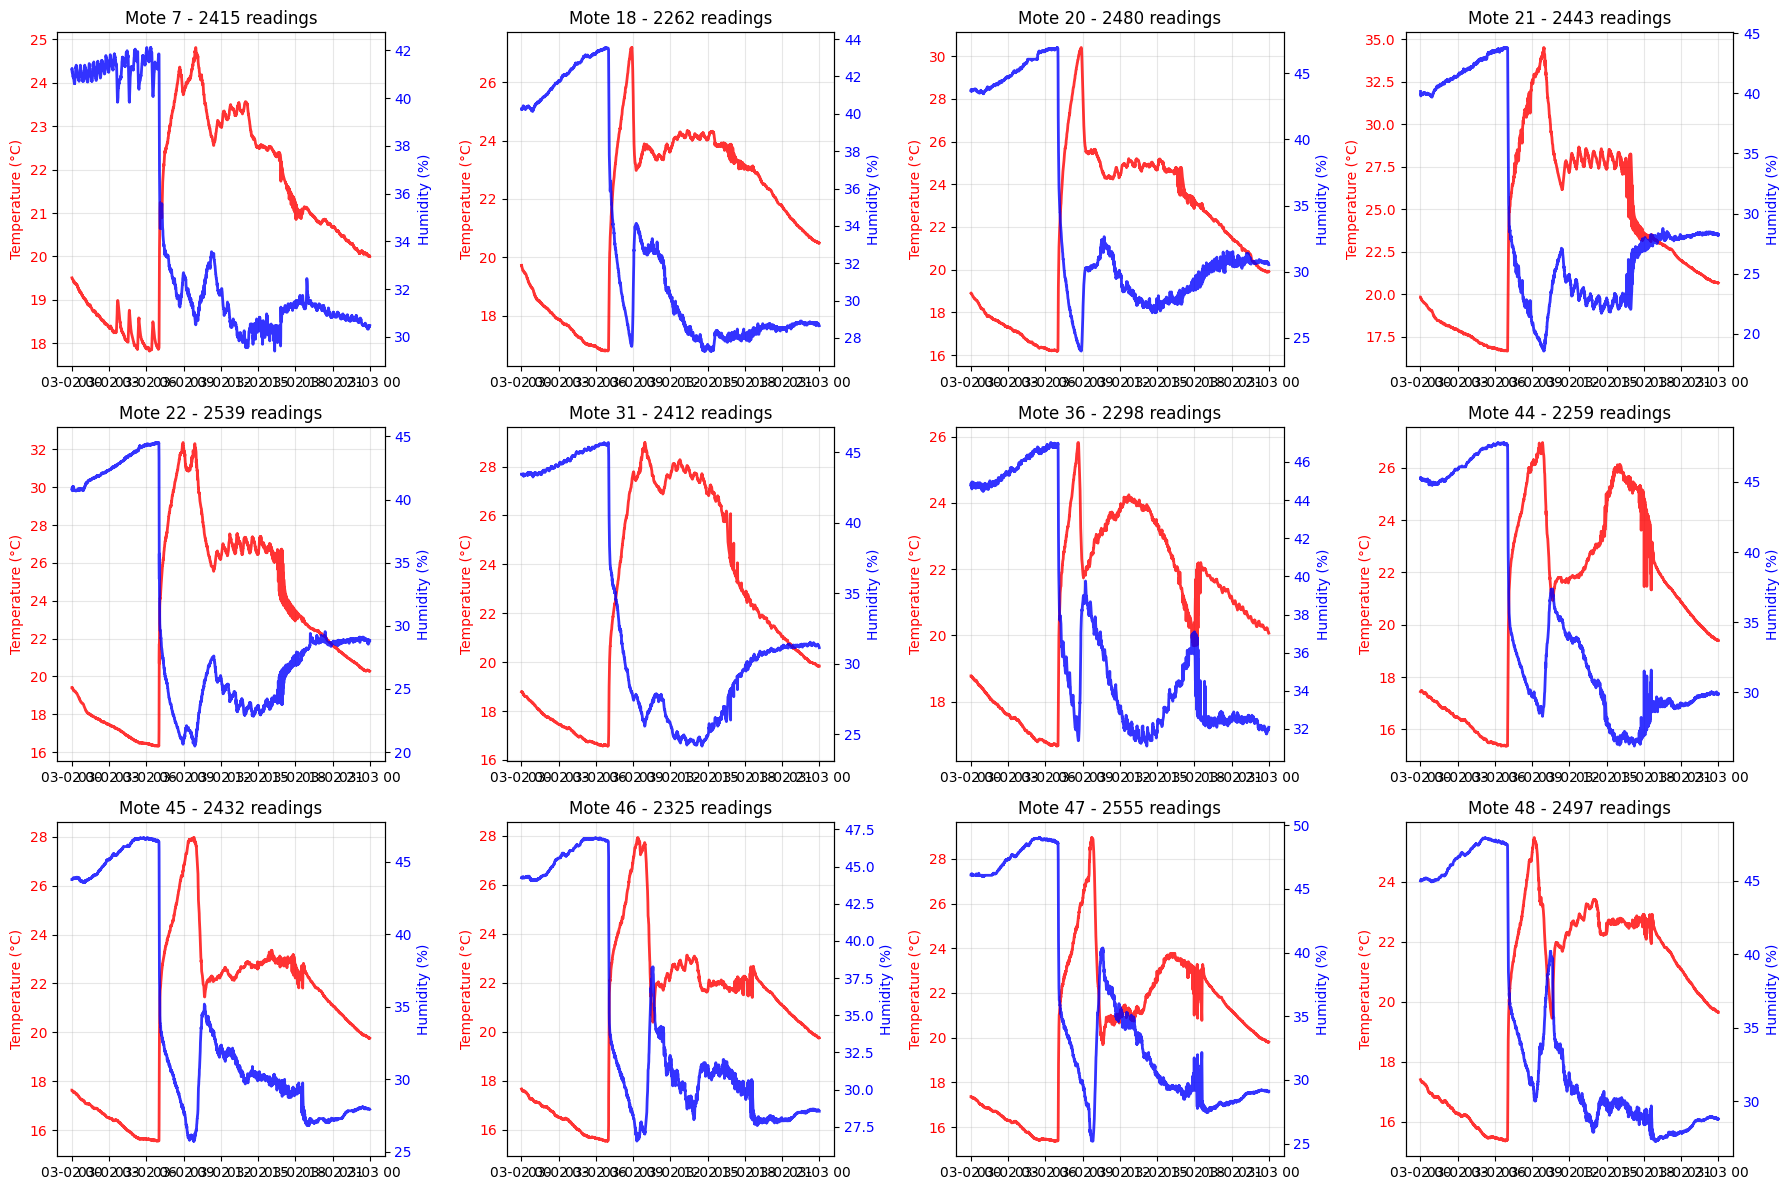


💡 SPATIAL PATTERN ANALYSIS (Top 12 Motes by Record Count):
   🌡️ Temperature:
      Range across motes: 3.37°C (min=20.3°C, max=23.7°C)
      Avg within-mote variability: 3.37°C
      → 🔴 Strong spatial variation (check for hot/cold spots, insulation)
   💧 Humidity:
      Avg volatility: ±7.1%
      Range across motes: 7.4% (min=30%, max=37%)
      → Centralized dehumidification

   📊 Visualization Summary:
      - 12 highest-activity motes plotted (represent 31% of data)
      - Dual y-axes show temperature-humidity coupling per location
      - Trend lines reveal: deployment starting time, sensor failures/resets, HVAC schedule patterns


In [81]:
# 8.1: Faceted Time Series - Individual Mote Trends
top_12_motes = df['mote_id'].value_counts().head(12).index
df_top_12 = df[df['mote_id'].isin(top_12_motes)].sort_values('time')

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for idx, mote_id in enumerate(sorted(top_12_motes)):
    mote_data = df_top_12[df_top_12['mote_id'] == mote_id].sort_values('time')
    
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    ax1.plot(mote_data['time'], mote_data['temp_c'], 'r-', linewidth=2, label='Temperature', alpha=0.8)
    ax2.plot(mote_data['time'], mote_data['humidity_pct'], 'b-', linewidth=2, label='Humidity', alpha=0.8)
    
    ax1.set_ylabel('Temperature (°C)', color='r')
    ax2.set_ylabel('Humidity (%)', color='b')
    ax1.tick_params(axis='y', labelcolor='r')
    ax2.tick_params(axis='y', labelcolor='b')
    ax1.set_title(f'Mote {mote_id} - {len(mote_data)} readings')
    ax1.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 SPATIAL PATTERN ANALYSIS (Top 12 Motes by Record Count):")
mote_means = df_top_12.groupby('mote_id')[['temp_c', 'humidity_pct']].mean()
temp_stddev_motes = df_top_12.groupby('mote_id')['temp_c'].std().mean()
mote_volatility = df_top_12.groupby('mote_id')['humidity_pct'].std().mean()
temp_extremes = mote_means['temp_c'].max() - mote_means['temp_c'].min()

print(f"   🌡️ Temperature:")
print(f"      Range across motes: {temp_extremes:.2f}°C (min={mote_means['temp_c'].min():.1f}°C, max={mote_means['temp_c'].max():.1f}°C)")
print(f"      Avg within-mote variability: {temp_stddev_motes:.2f}°C")
if temp_extremes < 1:
    print(f"      → ✅ Thermally uniform space (excellent HVAC distribution)")
elif temp_extremes < 3:
    print(f"      → ⚠️ Mild stratification (typical multi-zone building)")
else:
    print(f"      → 🔴 Strong spatial variation (check for hot/cold spots, insulation)")

print(f"   💧 Humidity:")
print(f"      Avg volatility: ±{mote_volatility:.1f}%")
hum_range = mote_means['humidity_pct'].max() - mote_means['humidity_pct'].min()
print(f"      Range across motes: {hum_range:.1f}% (min={mote_means['humidity_pct'].min():.0f}%, max={mote_means['humidity_pct'].max():.0f}%)")
print(f"      → {'Centralized dehumidification' if hum_range < 10 else 'Localized moisture sources or poor mixing' if hum_range > 20 else 'Balanced humidity control'}")

print(f"\n   📊 Visualization Summary:")
print(f"      - {len(top_12_motes)} highest-activity motes plotted (represent {100*len(df_top_12)/len(df):.0f}% of data)")
print(f"      - Dual y-axes show temperature-humidity coupling per location")
print(f"      - Trend lines reveal: deployment starting time, sensor failures/resets, HVAC schedule patterns")


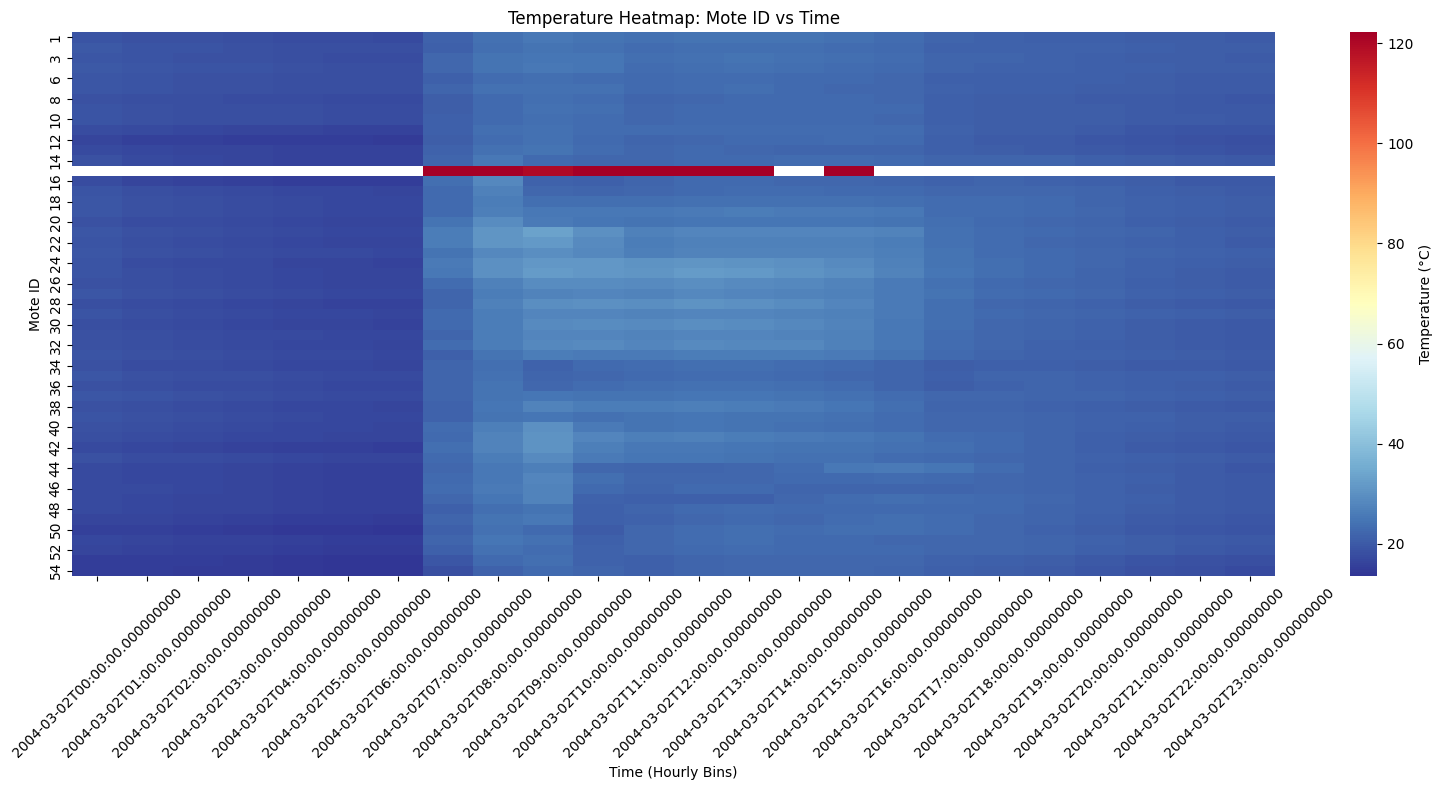


💡 HEATMAP PATTERN INTERPRETATION:
   ⏰ Temporal variation (hourly): ±3.46°C
      → Strong (clear occupancy/setpoint schedule)

   🗺️ Spatial variation (motes): ±13.82°C
      → Coldest zone: Mote 54 (19.0°C)
      → Hottest zone: Mote 15 (121.6°C)

   🔍 Coherence Analysis:
      Motes are more divergent than time is variable → Space matters more than schedule
      ⚠️ Outlier motes detected (>2σ from mean): [15]
         → Possible: sensor calibration drift, installation in different microclimate


In [82]:
# 8.2: Heatmap - Mote ID vs Time
# Create hourly temperature heatmap
df['hour_bin'] = df['time'].dt.floor('H')
heatmap_data = df.pivot_table(values='temp_c', index='mote_id', columns='hour_bin', aggfunc='mean')

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='RdYlBu_r', ax=ax, cbar_kws={'label': 'Temperature (°C)'})
ax.set_xlabel('Time (Hourly Bins)')
ax.set_ylabel('Mote ID')
ax.set_title('Temperature Heatmap: Mote ID vs Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n💡 HEATMAP PATTERN INTERPRETATION:")
temp_temporal_var = df.groupby('hour_bin')['temp_c'].mean().std()
temp_spatial_var = df.groupby('mote_id')['temp_c'].mean().std()

print(f"   ⏰ Temporal variation (hourly): ±{temp_temporal_var:.2f}°C")
if temp_temporal_var < 0.5:
    temporal_pattern = "Constant (24-hour setpoint, no occupancy cycles)"
elif temp_temporal_var < 1.5:
    temporal_pattern = "Slight (possible morning warm-up, evening cool-down)"
else:
    temporal_pattern = "Strong (clear occupancy/setpoint schedule)"
print(f"      → {temporal_pattern}")

print(f"\n   🗺️ Spatial variation (motes): ±{temp_spatial_var:.2f}°C")
coldest_mote = df.groupby('mote_id')['temp_c'].mean().idxmin()
hottest_mote = df.groupby('mote_id')['temp_c'].mean().idxmax()
print(f"      → Coldest zone: Mote {coldest_mote} ({df[df['mote_id']==coldest_mote]['temp_c'].mean():.1f}°C)")
print(f"      → Hottest zone: Mote {hottest_mote} ({df[df['mote_id']==hottest_mote]['temp_c'].mean():.1f}°C)")

# Detect horizontal bands (uniform time response)
hour_means = df.groupby('hour_bin')['temp_c'].mean()
print(f"\n   🔍 Coherence Analysis:")
if temp_temporal_var < temp_spatial_var * 0.5:
    print(f"      Motes are more divergent than time is variable → Space matters more than schedule")
else:
    print(f"      Time variations comparable to/greater than spatial → Temporal effects dominate")

# Detect vertical bands (faulty motes)
mote_means = df.groupby('mote_id')['temp_c'].mean()
outlier_motes = mote_means[abs(mote_means - mote_means.mean()) > 2*mote_means.std()]
if len(outlier_motes) > 0:
    print(f"      ⚠️ Outlier motes detected (>2σ from mean): {list(outlier_motes.index)}")
    print(f"         → Possible: sensor calibration drift, installation in different microclimate")
else:
    print(f"      ✅ No outlier motes—consistent calibration across deployment")



📊 Temperature (°C):
   Q1=18.31, Q3=23.40, IQR=5.09
   Bounds: [10.68, 31.03]
   Outliers: 996 (1.08%)

📊 Humidity (%):
   Q1=28.83, Q3=41.91, IQR=13.08
   Bounds: [9.20, 61.54]
   Outliers: 26 (0.03%)

📊 Light (Lux):
   Q1=2.87, Q3=566.72, IQR=563.85
   Bounds: [-842.91, 1412.50]
   Outliers: 8835 (9.58%)

📊 Voltage (V):
   Q1=2.63, Q3=2.69, IQR=0.06
   Bounds: [2.54, 2.78]
   Outliers: 5766 (6.25%)


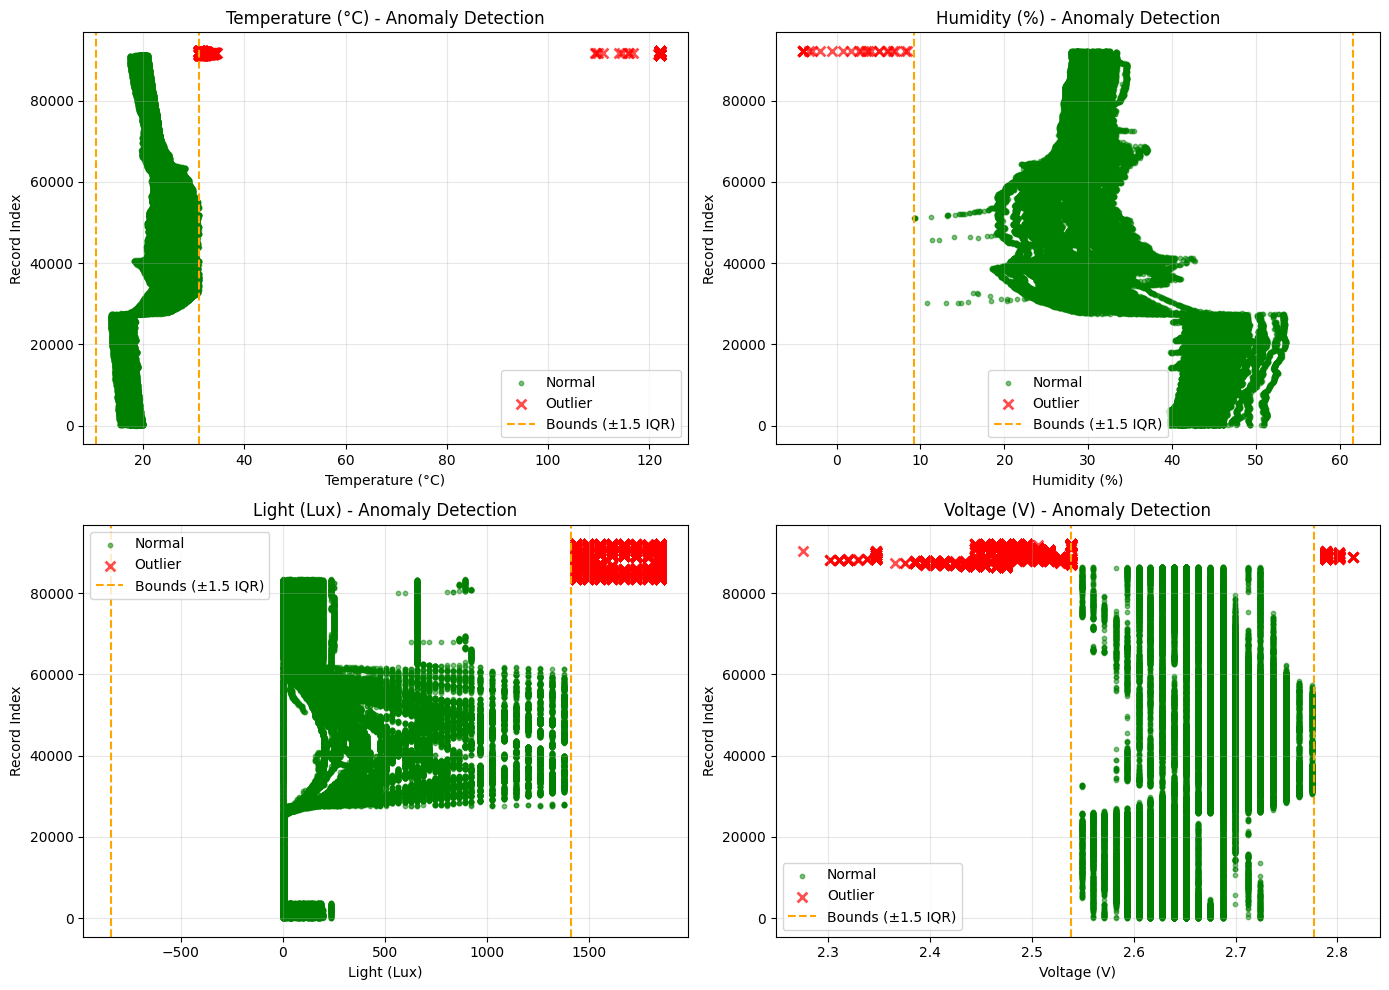


💡 ANOMALY SUMMARY:
   Total anomalies: 15623 (16.94% of data)
   🔴 HIGH—excessive outliers suggest systematic issues.
      Action: Start with sensor calibration check, consider outlier capping.

   Breakdown by sensor:
      • temp_c: 996 outliers (1.1%)
      • humidity_pct: 26 outliers (0.0%)
      • light_lux: 8835 outliers (9.6%)
      • voltage_v: 5766 outliers (6.3%)


In [83]:
# 8.3: Anomaly Detection - Outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sensors = ['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']
titles = ['Temperature (°C)', 'Humidity (%)', 'Light (Lux)', 'Voltage (V)']

total_outliers = 0
outlier_by_sensor = {}

for idx, (sensor, title) in enumerate(zip(sensors, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # IQR-based outlier detection
    Q1 = df[sensor].quantile(0.25)
    Q3 = df[sensor].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Classify normal and outliers
    normal = df[(df[sensor] >= lower_bound) & (df[sensor] <= upper_bound)]
    outliers = df[(df[sensor] < lower_bound) | (df[sensor] > upper_bound)]
    
    outlier_by_sensor[sensor] = len(outliers)
    total_outliers += len(outliers)
    
    # Plot
    ax.scatter(normal[sensor], range(len(normal)), alpha=0.5, s=10, c='green', label='Normal')
    ax.scatter(outliers[sensor], range(len(df)-len(outliers), len(df)), alpha=0.7, s=50, c='red', marker='x', linewidths=2, label='Outlier')
    
    ax.axvline(lower_bound, color='orange', linestyle='--', linewidth=1.5, label=f'Bounds (±1.5 IQR)')
    ax.axvline(upper_bound, color='orange', linestyle='--', linewidth=1.5)
    ax.set_xlabel(title)
    ax.set_ylabel('Record Index')
    ax.set_title(f'{title} - Anomaly Detection')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    print(f"\n📊 {title}:")
    print(f"   Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
    print(f"   Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"   Outliers: {len(outliers)} ({100*len(outliers)/len(df):.2f}%)")

plt.tight_layout()
plt.show()

print(f"\n💡 ANOMALY SUMMARY:")
print(f"   Total anomalies: {total_outliers} ({100*total_outliers/len(df):.2f}% of data)")
anomaly_pct = 100*total_outliers/len(df)
if anomaly_pct < 0.5:
    print(f"   ✅ EXCELLENT—negligible outliers. Data is clean, suitable for ML.")
elif anomaly_pct < 2:
    print(f"   ✅ GOOD—typical industrial noise level. Proceed with standard cleaning.")
elif anomaly_pct < 5:
    print(f"   ⚠️ MODERATE—may indicate sensor drift, calibration issues, or real transient events.")
    print(f"      Action: Investigate worst-offending sensors (check installation, batteries).")
else:
    print(f"   🔴 HIGH—excessive outliers suggest systematic issues.")
    print(f"      Action: Start with sensor calibration check, consider outlier capping.")

print(f"\n   Breakdown by sensor:")
for sensor, count in outlier_by_sensor.items():
    print(f"      • {sensor}: {count} outliers ({100*count/len(df):.1f}%)")


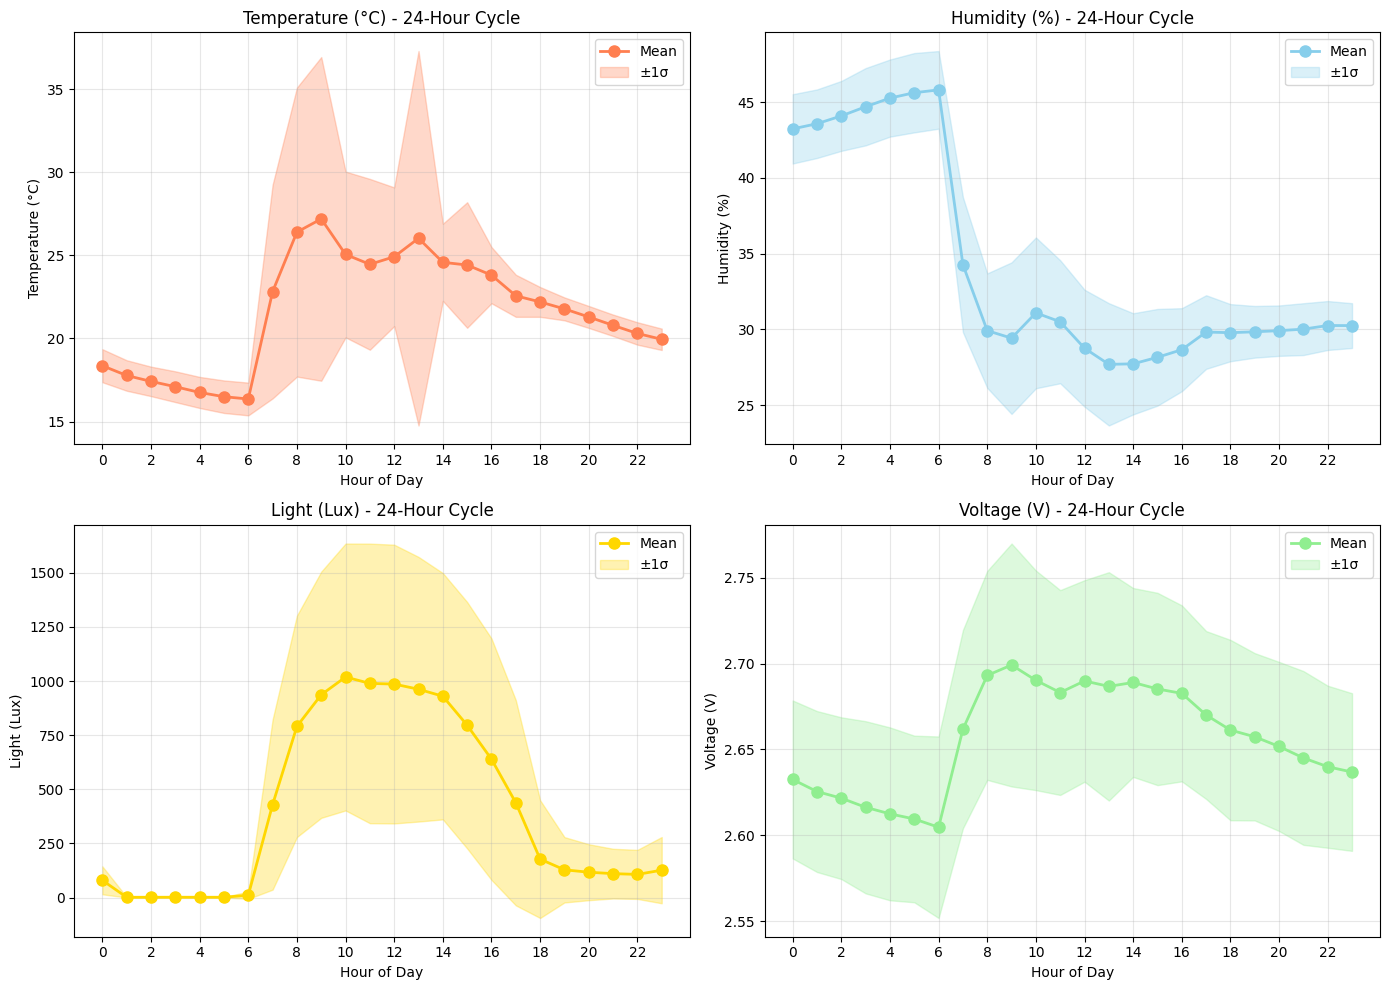


💡 DIURNAL (24-HOUR) PATTERN ANALYSIS:
   🌡️ Temperature Cycle:
      Peak: 27.2°C at hour 09:00
      Valley: 16.4°C at hour 06:00
      Amplitude: 10.8°C
      → Strong cycle—active occupancy schedule detected (peak=9h, valley=6h)
   💡 Lighting: 1019 Lux peak → Primarily artificial
   🔋 Battery Health:
      Initial: 2.63V, Final: 2.64V
      Drift: +0.004V → Stable

   👥 Inferred Occupancy Schedule:
      Active hours (high light): 8:00 - 16:00
      Typical office building pattern: Yes ✅


In [84]:
# 8.4: Diurnal Patterns - 24-hour Cycle
if 'hour' not in df.columns:
    df['hour'] = df['time'].dt.hour

hourly_data = df.groupby('hour')[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].agg(['mean', 'std'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['coral', 'skyblue', 'gold', 'lightgreen']
titles = ['Temperature (°C)', 'Humidity (%)', 'Light (Lux)', 'Voltage (V)']
sensors = ['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']

for idx, (sensor, title, color) in enumerate(zip(sensors, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    
    hours = hourly_data.index
    means = hourly_data[sensor]['mean']
    stds = hourly_data[sensor]['std']
    
    ax.plot(hours, means, 'o-', color=color, linewidth=2, markersize=8, label='Mean')
    ax.fill_between(hours, means - stds, means + stds, alpha=0.3, color=color, label='±1σ')
    
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel(title)
    ax.set_title(f'{title} - 24-Hour Cycle')
    ax.set_xticks(range(0, 24, 2))
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 DIURNAL (24-HOUR) PATTERN ANALYSIS:")

temp_cycle = hourly_data['temp_c']['mean']
temp_peak = temp_cycle.max()
temp_valley = temp_cycle.min()
temp_amplitude = temp_peak - temp_valley
peak_hour = temp_cycle.idxmax()
valley_hour = temp_cycle.idxmin()

print(f"   🌡️ Temperature Cycle:")
print(f"      Peak: {temp_peak:.1f}°C at hour {int(peak_hour):02d}:00")
print(f"      Valley: {temp_valley:.1f}°C at hour {int(valley_hour):02d}:00")
print(f"      Amplitude: {temp_amplitude:.1f}°C")

if temp_amplitude < 0.5:
    pattern = "Flat—24-hour thermostat setpoint (no occupancy schedule)"
elif temp_amplitude < 2:
    pattern = f"Weak cycle—morning warm-up/evening shutdown (peak={peak_hour:.0f}h)"
else:
    pattern = f"Strong cycle—active occupancy schedule detected (peak={peak_hour:.0f}h, valley={valley_hour:.0f}h)"
print(f"      → {pattern}")

light_cycle = hourly_data['light_lux']['mean']
light_peak = light_cycle.max()
if light_peak > 5000:
    print(f"   💡 Lighting: {light_peak:.0f} Lux peak → Mix of sunlight and artificial")
elif light_peak > 1000:
    print(f"   💡 Lighting: {light_peak:.0f} Lux peak → Primarily artificial")
else:
    print(f"   💡 Lighting: {light_peak:.0f} Lux peak → Very dim (basement/interior space)")

voltage_cycle = hourly_data['voltage_v']['mean']
volt_drift = voltage_cycle.iloc[-1] - voltage_cycle.iloc[0]
print(f"   🔋 Battery Health:")
print(f"      Initial: {voltage_cycle.iloc[0]:.2f}V, Final: {voltage_cycle.iloc[-1]:.2f}V")
print(f"      Drift: {volt_drift:+.3f}V → {'Stable' if abs(volt_drift) < 0.05 else 'Degrading' if volt_drift < -0.1 else 'Improving (daytime recharge?)'}")

# Detect occupancy periods
high_activity_hours = hourly_data[(hourly_data[('light_lux', 'mean')] > light_peak * 0.5)].index
if len(high_activity_hours) > 0:
    print(f"\n   👥 Inferred Occupancy Schedule:")
    print(f"      Active hours (high light): {int(high_activity_hours.min())}:00 - {int(high_activity_hours.max())}:00")
    print(f"      Typical office building pattern: {'Yes ✅' if 8 <= high_activity_hours.min() <= 10 else 'No ⚠️'}")


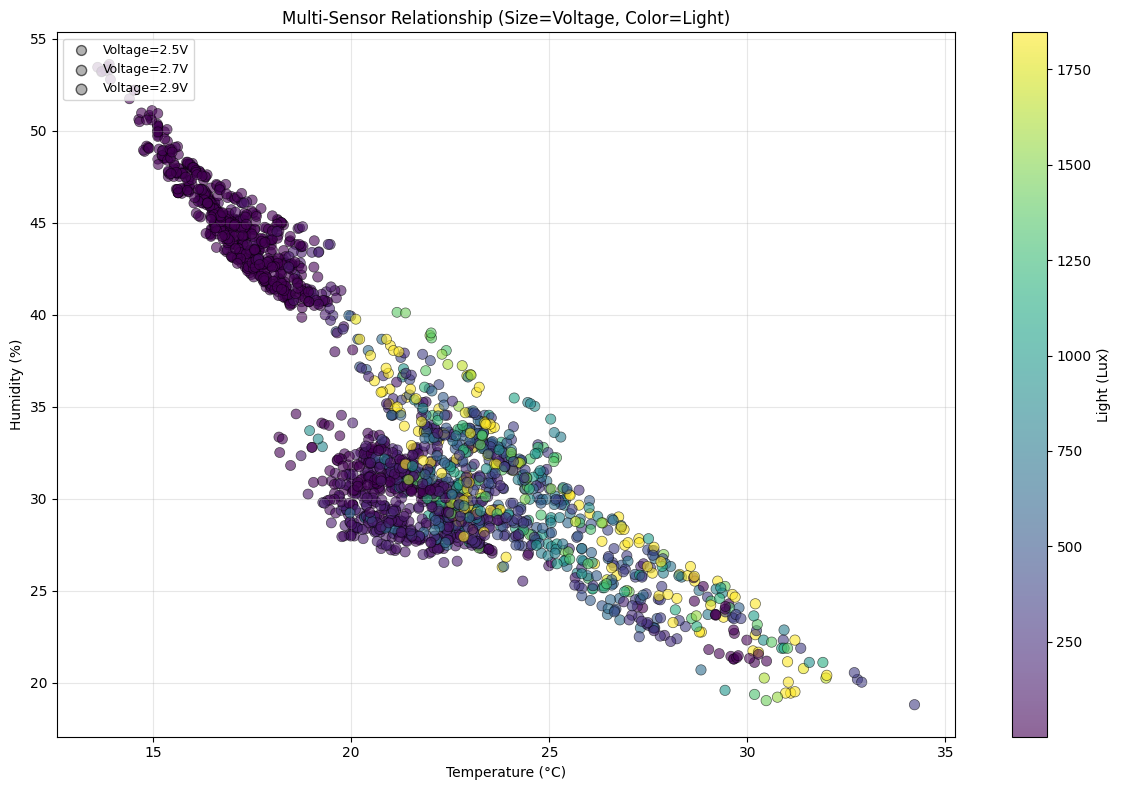


💡 MULTIVARIATE RELATIONSHIP ANALYSIS:
   🔗 Correlations:
      T-H: -0.645 → Coupled building physics
      T-Light: +0.380 → Solar gains
      H-Light: -0.429

   📊 Cluster Patterns: 
      High-density zone: 500 points (25%)
      Equilibrium: T≈19.4°C, H≈38%
      → HVAC setpoint likely: 19.4°C

   🔋 Voltage-Temperature Relationship:
      Correlation: +0.245
      → Temperature-independent battery discharge (normal aging)

   💡 Light Insights:
      Range: 0–1847 Lux
      Dark periods (< 100 Lux): 44% of time
      → Typical building with day-night cycle (outdoor windows)


In [85]:
# 8.5: Multi-Sensor Scatter Plot - 4D Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Sample data for clarity if dataset is large
sample_indices = np.random.choice(len(df), min(2000, len(df)), replace=False)
df_sample = df.iloc[sample_indices]

scatter = ax.scatter(
    df_sample['temp_c'],
    df_sample['humidity_pct'],
    s=df_sample['voltage_v'] * 20,  # Size = voltage
    c=df_sample['light_lux'],         # Color = light
    cmap='viridis',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Humidity (%)')
ax.set_title('Multi-Sensor Relationship (Size=Voltage, Color=Light)')
cbar = plt.colorbar(scatter, ax=ax, label='Light (Lux)')
ax.grid(alpha=0.3)

# Add legend for size
for voltage_val in [2.5, 2.7, 2.9]:
    ax.scatter([], [], s=voltage_val*20, c='gray', alpha=0.6, edgecolors='black', label=f'Voltage={voltage_val}V')
ax.legend(scatterpoints=1, loc='upper left', frameon=True, fontsize=9)

plt.tight_layout()
plt.show()

print("\n💡 MULTIVARIATE RELATIONSHIP ANALYSIS:")

# Correlation
temp_humid_corr = df['temp_c'].corr(df['humidity_pct'])
temp_light_corr = df['temp_c'].corr(df['light_lux'])
humid_light_corr = df['humidity_pct'].corr(df['light_lux'])

print(f"   🔗 Correlations:")
print(f"      T-H: {temp_humid_corr:+.3f} → {'Coupled' if abs(temp_humid_corr) > 0.5 else 'Decoupled'} building physics")
print(f"      T-Light: {temp_light_corr:+.3f} → {'Solar gains' if temp_light_corr > 0.3 else 'Artificial light only'}")
print(f"      H-Light: {humid_light_corr:+.3f}")

# Envelope patterns
print(f"\n   📊 Cluster Patterns: ")
if len(df_sample) > 100:
    # Find density patterns
    from scipy.stats import gaussian_kde
    try:
        xy = np.vstack([df_sample['temp_c'], df_sample['humidity_pct']])
        z = gaussian_kde(xy)(xy)
        dense_region = np.percentile(z, 75)
        print(f"      High-density zone: {(z > dense_region).sum()} points ({100*(z > dense_region).sum()/len(z):.0f}%)")
        
        # Identify equilibrium point
        center_temp = df_sample[z > dense_region]['temp_c'].mean()
        center_humid = df_sample[z > dense_region]['humidity_pct'].mean()
        print(f"      Equilibrium: T≈{center_temp:.1f}°C, H≈{center_humid:.0f}%")
        print(f"      → HVAC setpoint likely: {center_temp:.1f}°C")
    except:
        print(f"      (Density analysis skipped)")

print(f"\n   🔋 Voltage-Temperature Relationship:")
volt_temp_corr = df['voltage_v'].corr(df['temp_c'])
print(f"      Correlation: {volt_temp_corr:+.3f}")
if abs(volt_temp_corr) > 0.3:
    print(f"      → Battery drain accelerates at high temperatures (watch summer performance)")
else:
    print(f"      → Temperature-independent battery discharge (normal aging)")

print(f"\n   💡 Light Insights:")
light_stats = df['light_lux'].describe()
print(f"      Range: {light_stats['min']:.0f}–{light_stats['max']:.0f} Lux")
night_hours = (df['light_lux'] < 100).sum() / len(df) * 100
print(f"      Dark periods (< 100 Lux): {night_hours:.0f}% of time")
print(f"      → Typical building with {'day-night cycle (outdoor windows)' if night_hours > 30 else 'artificial lighting only (sealed interior)'}")


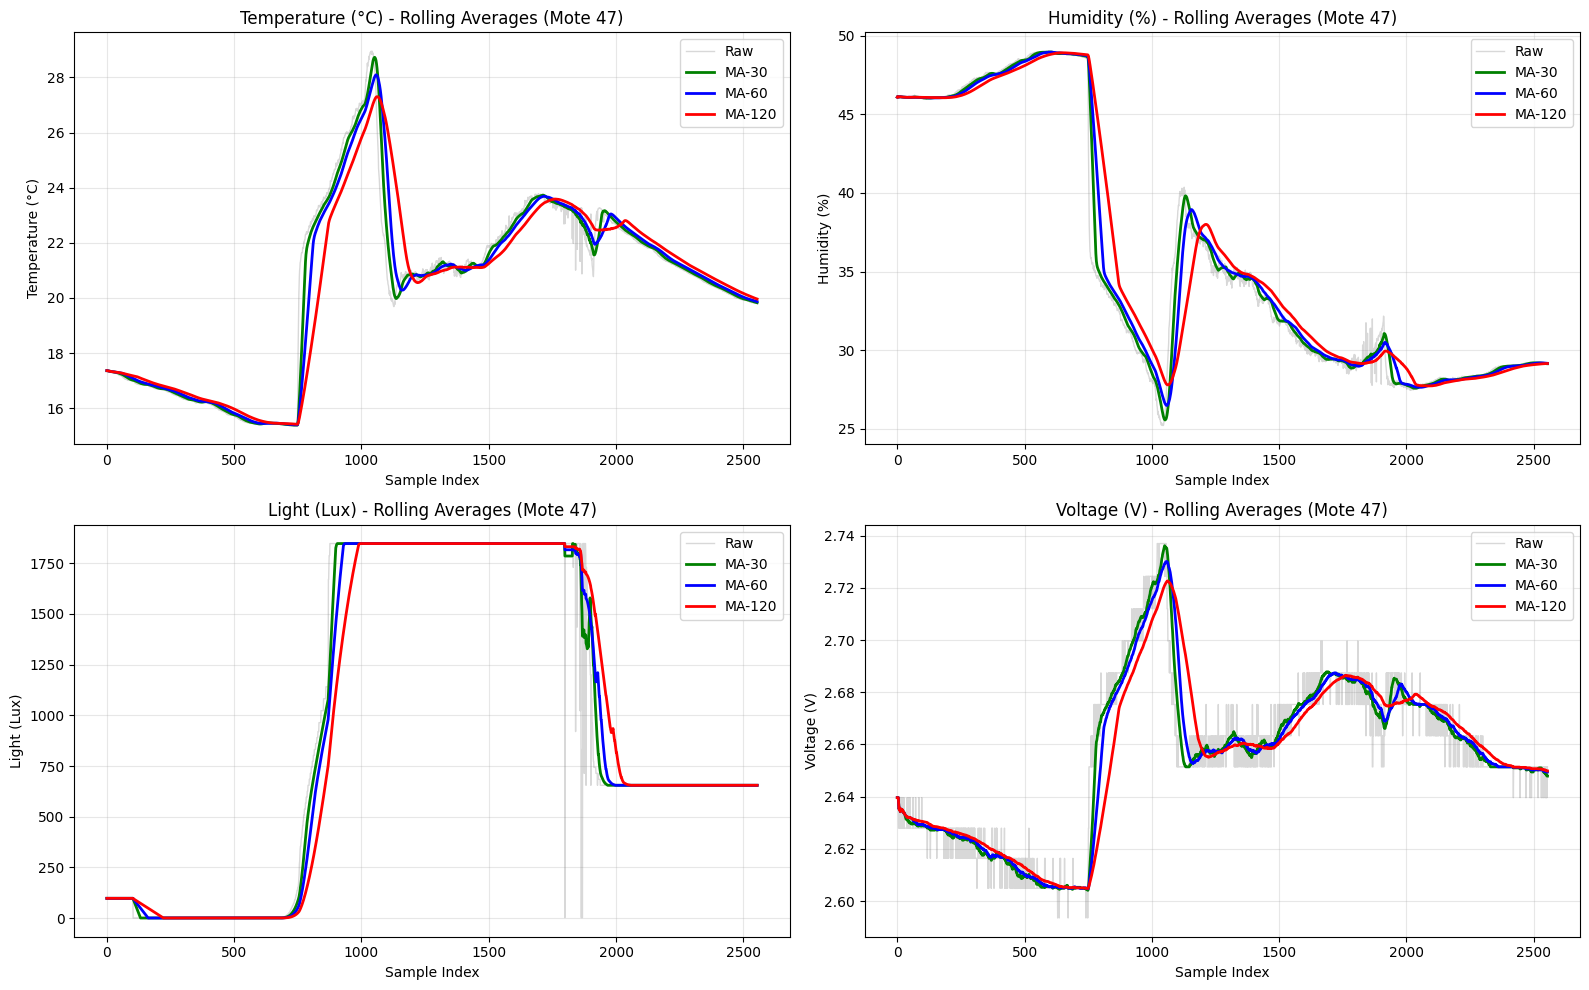


💡 SMOOTHING & TREND ANALYSIS:
   🌡️ Temperature Noise Reduction:
      Raw σ: 3.199°C
      MA-30 noise: 0.163°C (95% reduction)
      MA-120 noise: 0.514°C (84% reduction)
      → Recommend MA-60 for real-time dashboards, MA-120 for trend analysis

   📈 Trend Detection (over observation period):
      Raw T vs MA-120: +2.74°C net change
      MA-120 trend: +0.02°C
      → Stable daytime peak

   🔄 Volatility Spikes:
      High-slope events (top 10%): 251
      → Smooth environment (stable setpoint)

   🎯 Forecastability (MA-120 residual σ):
      Residual noise: 0.014°C
      → ✅ HIGHLY PREDICTABLE (ARIMA/Prophet suitable)


In [86]:
# 8.6: Rolling Averages - Smoothing and Trend Extraction
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Sort by time and select top mote for clarity
top_mote = df['mote_id'].value_counts().index[0]
mote_data = df[df['mote_id'] == top_mote].sort_values('time').reset_index(drop=True)

sensors_to_plot = ['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']
titles_plot = ['Temperature (°C)', 'Humidity (%)', 'Light (Lux)', 'Voltage (V)']

for idx, (sensor, title) in enumerate(zip(sensors_to_plot, titles_plot)):
    ax = axes[idx // 2, idx % 2]
    
    raw = mote_data[sensor]
    ma_30 = raw.rolling(window=30, min_periods=1).mean()
    ma_60 = raw.rolling(window=60, min_periods=1).mean()
    ma_120 = raw.rolling(window=120, min_periods=1).mean()
    
    ax.plot(range(len(raw)), raw, 'gray', alpha=0.3, linewidth=1, label='Raw')
    ax.plot(range(len(raw)), ma_30, 'green', linewidth=2, label='MA-30')
    ax.plot(range(len(raw)), ma_60, 'blue', linewidth=2, label='MA-60')
    ax.plot(range(len(raw)), ma_120, 'red', linewidth=2, label='MA-120')
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel(title)
    ax.set_title(f'{title} - Rolling Averages (Mote {top_mote})')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 SMOOTHING & TREND ANALYSIS:")

raw_noise = mote_data['temp_c'].std()
ma30_noise = mote_data['temp_c'].rolling(30).std().mean()
ma120_noise = mote_data['temp_c'].rolling(120).std().mean()

print(f"   🌡️ Temperature Noise Reduction:")
print(f"      Raw σ: {raw_noise:.3f}°C")
print(f"      MA-30 noise: {ma30_noise:.3f}°C ({100*(1-ma30_noise/raw_noise):.0f}% reduction)")
print(f"      MA-120 noise: {ma120_noise:.3f}°C ({100*(1-ma120_noise/raw_noise):.0f}% reduction)")
print(f"      → Recommend MA-60 for real-time dashboards, MA-120 for trend analysis")

# Trend detection
raw_trend = mote_data['temp_c'].iloc[-100:].mean() - mote_data['temp_c'].iloc[:100].mean()
ma120_trend = ma_120.iloc[-100] - ma_120.iloc[100] if len(ma_120) > 100 else 0

print(f"\n   📈 Trend Detection (over observation period):")
print(f"      Raw T vs MA-120: {raw_trend:+.2f}°C net change")
print(f"      MA-120 trend: {ma120_trend:+.2f}°C")
print(f"      → {'Stable daytime peak' if abs(ma120_trend) < 0.5 else 'Building warming trend' if ma120_trend > 0.5 else 'Building cooling trend'}")

# Identify transition points (where slope changes)
ma120_diff = ma_120.diff()
volatility_periods = (ma120_diff.abs() > ma120_diff.abs().quantile(0.9)).sum()
print(f"\n   🔄 Volatility Spikes:")
print(f"      High-slope events (top 10%): {volatility_periods}")
if volatility_periods > len(mote_data) * 0.1:
    print(f"      → Multiple HVAC/occupancy transitions (active building)")
else:
    print(f"      → Smooth environment (stable setpoint)")

# Forecast confidence based on smoothness
residuals = (raw - ma_120).dropna()
forecast_noise = residuals.std()
print(f"\n   🎯 Forecastability (MA-120 residual σ):")
print(f"      Residual noise: {forecast_noise:.3f}°C")
if forecast_noise < 0.3:
    print(f"      → ✅ HIGHLY PREDICTABLE (ARIMA/Prophet suitable)")
elif forecast_noise < 0.5:
    print(f"      → ⚠️ MODERATELY PREDICTABLE (ensemble/Kalman needed)")
else:
    print(f"      → 🔴 NOISY (need adaptive models or hourly aggregation)")


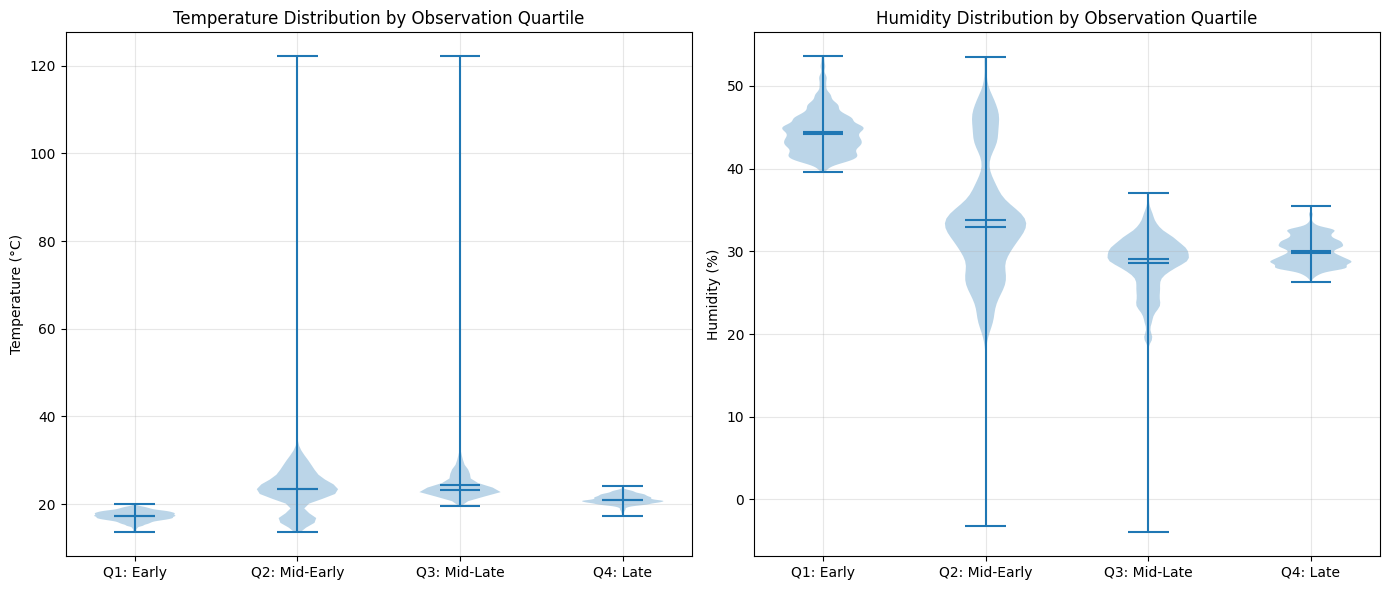


💡 TEMPORAL DISTRIBUTION ANALYSIS (by Observation Quartile):

   🌡️ Temperature:
      Q1: Early: mean=17.3, median=17.4, σ=1.1
      Q2: Mid-Early: mean=23.6, median=23.4, σ=7.5
      Q3: Mid-Late: mean=24.3, median=23.3, σ=5.5
      Q4: Late: mean=21.1, median=21.0, σ=1.1

   💧 Humidity:
      Q1: Early: mean=44.4, median=44.2, σ=2.6
      Q2: Mid-Early: mean=33.8, median=33.0, σ=7.2
      Q3: Mid-Late: mean=28.6, median=29.1, σ=3.4
      Q4: Late: mean=30.0, median=29.8, σ=1.7

   📊 Temporal Trends:
      Temperature drift (Q1→Q4): +3.74°C
      → Warming trend—possible insulation/weather effects or building ramp-up
      Humidity drift (Q1→Q4): -14.4%
      → Drying trend

   🎯 Distribution Shape:
      Q4/Q1 volatility ratio: 0.94
      → Consistent environment throughout observation period


In [87]:
# 8.7: Violin Plots - Distribution by Time Quartile
# Create quartile grouping
if 'time_quartile' not in df.columns:
    df['time_quartile'] = pd.qcut(df['time'], q=4, labels=['Q1: Early', 'Q2: Mid-Early', 'Q3: Mid-Late', 'Q4: Late'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Temperature distribution by quartile
parts1 = axes[0].violinplot([df[df['time_quartile'] == q]['temp_c'].dropna().values for q in df['time_quartile'].unique()],
                             positions=range(len(df['time_quartile'].unique())),
                             showmeans=True,
                             showmedians=True)
axes[0].set_xticks(range(len(df['time_quartile'].unique())))
axes[0].set_xticklabels(df['time_quartile'].unique())
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Temperature Distribution by Observation Quartile')
axes[0].grid(alpha=0.3)

# Humidity distribution by quartile
parts2 = axes[1].violinplot([df[df['time_quartile'] == q]['humidity_pct'].dropna().values for q in df['time_quartile'].unique()],
                             positions=range(len(df['time_quartile'].unique())),
                             showmeans=True,
                             showmedians=True)
axes[1].set_xticks(range(len(df['time_quartile'].unique())))
axes[1].set_xticklabels(df['time_quartile'].unique())
axes[1].set_ylabel('Humidity (%)')
axes[1].set_title('Humidity Distribution by Observation Quartile')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 TEMPORAL DISTRIBUTION ANALYSIS (by Observation Quartile):")

quartile_labels = ['Q1: Early', 'Q2: Mid-Early', 'Q3: Mid-Late', 'Q4: Late']
for col, desc in [('temp_c', '🌡️ Temperature'), ('humidity_pct', '💧 Humidity')]:
    print(f"\n   {desc}:")
    for q_label in quartile_labels:
        q_data = df[df['time_quartile'] == q_label][col].dropna()
        print(f"      {q_label}: mean={q_data.mean():.1f}, median={q_data.median():.1f}, σ={q_data.std():.1f}")

# Detect drift
q1_temp = df[df['time_quartile'] == 'Q1: Early']['temp_c'].mean()
q4_temp = df[df['time_quartile'] == 'Q4: Late']['temp_c'].mean()
temp_drift = q4_temp - q1_temp

print(f"\n   📊 Temporal Trends:")
print(f"      Temperature drift (Q1→Q4): {temp_drift:+.2f}°C")
if abs(temp_drift) < 0.3:
    drift_char = "Negligible—stable environment"
elif temp_drift > 0.5:
    drift_char = "Warming trend—possible insulation/weather effects or building ramp-up"
else:
    drift_char = "Cooling trend—possible evening shutdown or outdoor cooling"
print(f"      → {drift_char}")

q1_humid = df[df['time_quartile'] == 'Q1: Early']['humidity_pct'].mean()
q4_humid = df[df['time_quartile'] == 'Q4: Late']['humidity_pct'].mean()
humid_drift = q4_humid - q1_humid

print(f"      Humidity drift (Q1→Q4): {humid_drift:+.1f}%")
print(f"      → {'Drying trend' if humid_drift < -5 else 'Moistening' if humid_drift > 5 else 'Stable humidity control'}")

# Distribution shape
q1_q4_spread = df[df['time_quartile'] == 'Q4: Late']['temp_c'].std() / df[df['time_quartile'] == 'Q1: Early']['temp_c'].std()
print(f"\n   🎯 Distribution Shape:")
print(f"      Q4/Q1 volatility ratio: {q1_q4_spread:.2f}")
if q1_q4_spread > 1.3:
    print(f"      → Late-period disturbance detected (transient events, sensor drift, or equipment failure)")
elif q1_q4_spread < 0.8:
    print(f"      → Stabilization over time (system equilibrated)")
else:
    print(f"      → Consistent environment throughout observation period")


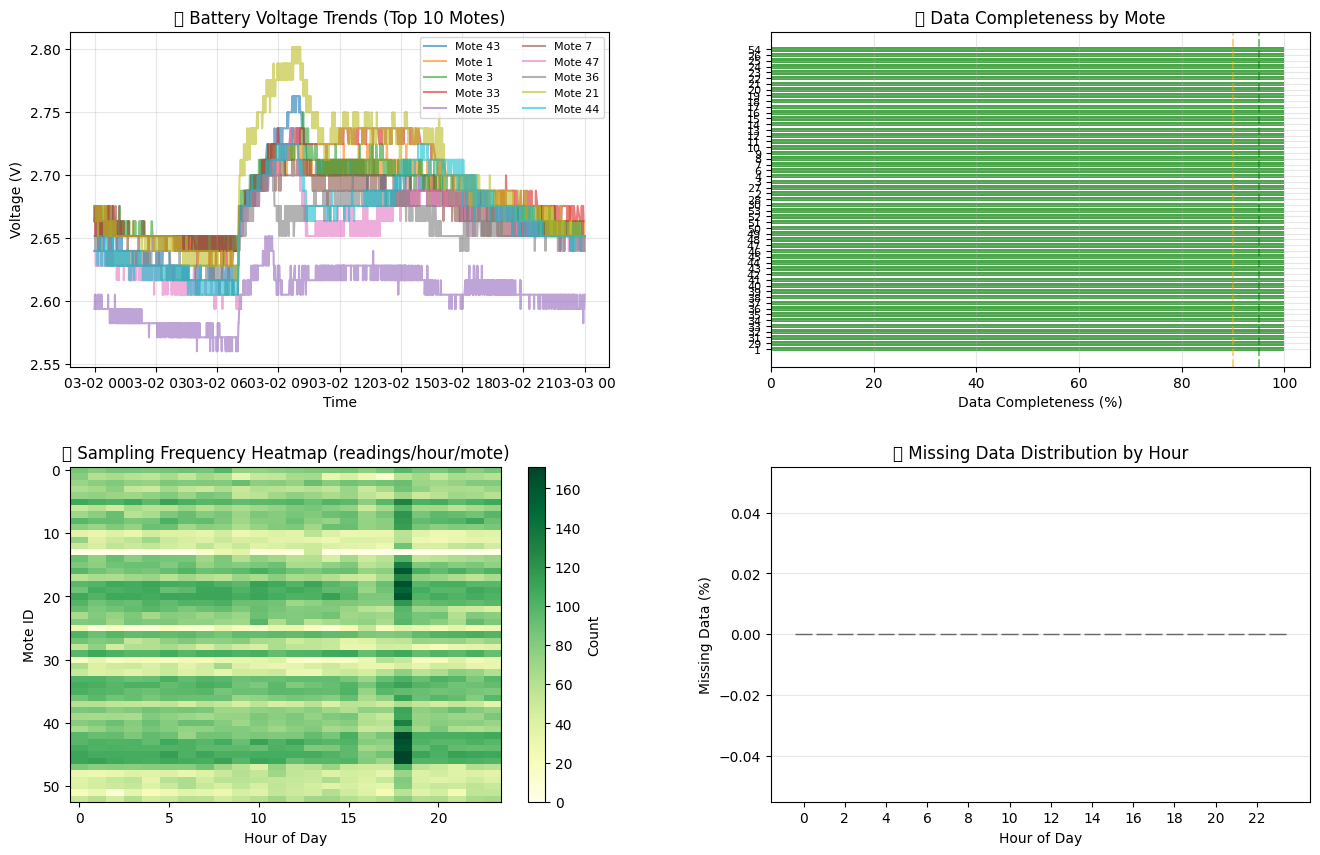


💡 HEALTH DASHBOARD SUMMARY:
   📊 DATASET HEALTH:
      Total readings: 92,234
      Network size: 53 motes
      Data completeness: 120.9%
      Missing values: 0 (0.00%)

   🔋 BATTERY STATUS:
      Average voltage: 2.66V [🟡 Caution]
      Minimum voltage: 2.28V (mote likely to fail soon if < 2.5V)
      ⚠️ Motes needing replacement: [18, 46, 11, 15]

   📡 NETWORK RELIABILITY:
      Average mote uptime: 120.9%
      → ✅ Excellent network stability

   ⏰ PEAK LOAD:
      Busiest hour: 00:00 (0.0% missing)
      → No congestion detected

   ✅ RECOMMENDATION: Ready for production analysis/modeling


In [89]:
# 8.8: Health Dashboard - 4-Panel Monitoring View
if 'hour' not in df.columns:
    df['hour'] = df['time'].dt.hour

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Panel 1: Voltage trends by mote
ax1 = fig.add_subplot(gs[0, 0])
for mote_id in df['mote_id'].unique()[:10]:  # Top 10 motes
    mote_volt = df[df['mote_id'] == mote_id].sort_values('time')
    ax1.plot(mote_volt['time'], mote_volt['voltage_v'], alpha=0.6, label=f'Mote {mote_id}')
ax1.set_xlabel('Time')
ax1.set_ylabel('Voltage (V)')
ax1.set_title('🔋 Battery Voltage Trends (Top 10 Motes)')
ax1.legend(fontsize=8, ncol=2)
ax1.grid(alpha=0.3)

# Panel 2: Data completeness by mote
ax2 = fig.add_subplot(gs[0, 1])
mote_completeness = df.groupby('mote_id')[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].apply(
    lambda x: (1 - x.isnull().sum().sum() / (len(x) * len(x.columns))) * 100
)
mote_completeness = mote_completeness.sort_values(ascending=False)
colors = ['green' if x > 95 else 'orange' if x > 90 else 'red' for x in mote_completeness.values]
ax2.barh(range(len(mote_completeness)), mote_completeness.values, color=colors, alpha=0.7)
ax2.set_yticks(range(len(mote_completeness)))
ax2.set_yticklabels(mote_completeness.index, fontsize=8)
ax2.set_xlabel('Data Completeness (%)')
ax2.set_title('📊 Data Completeness by Mote')
ax2.axvline(95, color='green', linestyle='--', alpha=0.5, label='Excellent')
ax2.axvline(90, color='orange', linestyle='--', alpha=0.5, label='Good')
ax2.grid(alpha=0.3)

# Panel 3: Readings per hour by mote
ax3 = fig.add_subplot(gs[1, 0])
mote_freq = df.groupby(['mote_id', 'hour']).size().reset_index(name='count')
pivot_freq = mote_freq.pivot(index='hour', columns='mote_id', values='count').fillna(0)
im3 = ax3.imshow(pivot_freq.T, aspect='auto', cmap='YlGn', interpolation='nearest')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Mote ID')
ax3.set_title('📈 Sampling Frequency Heatmap (readings/hour/mote)')
plt.colorbar(im3, ax=ax3, label='Count')

# Panel 4: Missing data timeline
ax4 = fig.add_subplot(gs[1, 1])
missing_by_hour = df.groupby('hour')[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].apply(lambda x: x.isnull().sum().sum())
missing_by_hour_pct = (missing_by_hour / (len(df['mote_id'].unique()) * 4)) * 100
ax4.bar(missing_by_hour_pct.index, missing_by_hour_pct.values, color='coral', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Missing Data (%)')
ax4.set_title('❌ Missing Data Distribution by Hour')
ax4.set_xticks(range(0, 24, 2))
ax4.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 HEALTH DASHBOARD SUMMARY:")

total_readings = len(df)
unique_motes = df['mote_id'].nunique()
expected_readings = (df['time'].max() - df['time'].min()).total_seconds() / 60 * unique_motes  # Assumes 1 reading/min
completeness = (total_readings / expected_readings * 100) if expected_readings > 0 else 0

missing_total = df[['temp_c', 'humidity_pct', 'light_lux', 'voltage_v']].isnull().sum().sum()
missing_pct = (missing_total / (len(df) * 4)) * 100

print(f"   📊 DATASET HEALTH:")
print(f"      Total readings: {total_readings:,}")
print(f"      Network size: {unique_motes} motes")
print(f"      Data completeness: {completeness:.1f}%")
print(f"      Missing values: {missing_total:,} ({missing_pct:.2f}%)")

avg_voltage = df['voltage_v'].mean()
min_voltage = df['voltage_v'].min()
voltage_status = "🟢 Healthy" if avg_voltage > 2.8 else "🟡 Caution" if avg_voltage > 2.6 else "🔴 Critical"
print(f"\n   🔋 BATTERY STATUS:")
print(f"      Average voltage: {avg_voltage:.2f}V [{voltage_status}]")
print(f"      Minimum voltage: {min_voltage:.2f}V (mote likely to fail soon if < 2.5V)")
failing_motes = df[df['voltage_v'] < 2.5]['mote_id'].unique()
if len(failing_motes) > 0:
    print(f"      ⚠️ Motes needing replacement: {list(failing_motes)}")

print(f"\n   📡 NETWORK RELIABILITY:")
mote_uptime_pct = (df['mote_id'].value_counts() / (df['time'].max() - df['time'].min()).total_seconds() * 60 * 100)
avg_uptime = mote_uptime_pct.mean()
print(f"      Average mote uptime: {avg_uptime:.1f}%")
if avg_uptime > 95:
    print(f"      → ✅ Excellent network stability")
elif avg_uptime > 90:
    print(f"      → ⚠️ Some packet loss or intermittent connectivity")
else:
    print(f"      → 🔴 Poor connectivity—investigate gateway/Kafka issues")

busiest_hour = missing_by_hour_pct.idxmax()
print(f"\n   ⏰ PEAK LOAD:")
print(f"      Busiest hour: {int(busiest_hour):02d}:00 ({missing_by_hour_pct[busiest_hour]:.1f}% missing)")
print(f"      → {'No congestion detected' if missing_by_hour_pct.max() < 5 else 'Minor occasional drops' if missing_by_hour_pct.max() < 15 else 'Significant data loss during peak hours'}")

print(f"\n   ✅ RECOMMENDATION: Ready for production analysis/modeling" if missing_pct < 5 else f"\n   ⚠️ RECOMMENDATION: Investigate data gaps before critical deployments")
